# Explainer Notebook - Movie/TV show network

### Contribution Statement

Team Members:

- Mia 
- Kristian
- Malika (s247370)

All team members contributed equally to all parts.

Link to the website: https://github.com/s234829/-02467_Project/wiki

In [137]:
# Standard library imports
import os
import gzip
import json
import ast
import re
from collections import defaultdict, Counter

# Data manipulation and numerical operations
import numpy as np
import pandas as pd
import math
from matplotlib.ticker import MaxNLocator

# Parallel processing and progress tracking
from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

# Natural Language Processing
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Graph and network analysis
import networkx as nx
from networkx.readwrite import json_graph
import netwulf as nw
import community as community_louvain  # Louvain algorithm for community detection

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Use with the image plotter
import requests
from io import BytesIO
from PIL import Image 

# Download necessary NLTK data
nltk.download('vader_lexicon')

# Set random seed for reproducibility (Louvain algorithm)
np.random.seed(seed=100)  


[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


# Table of Contents

- [Motivation](##motivation)
- [The Dataset and Basic Statistics](##the-dataset-and-basic-statistics)
- [Tools, Theory and Analysis](##tools-theory-and-analysis)
    - [Community analysis](###community-analysis)
    - [Assortativity](#assortativity)
    - [Centrality](#centrality)
    - [Sentiment score distribution](#sentiment-score-distribution)
    - [Sentiment category distribution](#sentiment-category-distribution)
    - [Word clouds based on TF-IDF](#word-clouds-for-the-identified-communities)
- [Discussion](#discussion)

## Motivation


## The Dataset and Basic Statistics

Our dataset is a subset of the "Amazon Reviews" dataset collected in 2023 by McAuley Lab:

Link to dataset: https://amazon-reviews-2023.github.io/

We are not interested in the entire 571M+ reviews but will be looking specifically at the "Movies_and_TV" subset. Each subset is divided into two .csv files, a review and a metadata.

The review contains - as the name would suggest - the reviews themselves. With zero cleaning, the combined dataset is around 7GB. Almost immediately there are large portions of the dataset we deem to not be relevant data and so we will be shrinking the usable dataset, to get a much cleaner and more potent dataset for the purposes of creating the co-reviewer graph. 

Firstly, an overview of the columns in each dataset:

| Reviews             | Description                                                                 |
|--------------------|-----------------------------------------------------------------------------|
| `rating`           | Star rating given by the reviewer (e.g., 1 to 5)                            |
| `title`            | Title or headline of the review                                             |
| `text`             | The main body text of the review                                            |
| `images`           | Image URLs or attachments included with the review (if any)                 |
| `asin`             | Amazon Standard Identification Number for the specific product              |
| `parent_asin`      | Group identifier to cluster product variants                                |
| `user_id`          | Anonymized unique identifier for the reviewer                               |
| `timestamp`        | Time the review was posted (UNIX or ISO format)                             |
| `helpful_vote`     | Number of people who found the review helpful                               |
| `verified_purchase`| Boolean indicating whether the purchase was verified by Amazon             |

| Metadata           | Description                                                                 |
|------------------|-----------------------------------------------------------------------------|
| `main_category`  | The top-level category the product belongs to (e.g., "Movies & TV")         |
| `title`          | The main product title (often the movie/show title)                         |
| `subtitle`       | Optional subtitle for the product (e.g., edition/version info)              |
| `average_rating` | The average customer rating for the product                                 |
| `rating_number`  | Total number of ratings the product has received                            |
| `features`       | A list of product features (e.g., language, format)                         |
| `description`    | A longer description or summary of the product                              |
| `price`          | The listed price of the product                                              |
| `images`         | A list of image URLs associated with the product                            |
| `videos`         | Video media links (e.g., trailers or previews), if available                |
| `store`          | The Amazon store/subcategory under which the product is listed              |
| `categories`     | List of categories/tags assigned to the product (e.g., genre, theme)        |
| `details`        | Additional technical or marketing metadata (format, region, etc.)           |
| `parent_asin`    | A group-level identifier for versions of the same product                   |


A couple of these drastically reduce the size like, `helpful_vote` and `verified_purchase`. We decided to remove these because reviews without a helpful vote proably isn't very high quality, or irrelevant. Similarly, if the purchase can't be verified we can't be certain that the review comes from a real user. Reviews with less than 10 words were also deemed to be of lesser quality; The goal is to find descriptive reviews to facilitate language processing. 

Lastly, we removed products that had less than 15 total reviews. These would needlessly bloat our dataset, and make it more noisy. A large portion of the dataset contains products with minimal engagement, these would not facilitate community detection well. We summarized the compression in the table:

| Step                                                  | Description                                                  | Count / Shape          |
|-------------------------------------------------------|--------------------------------------------------------------|------------------------|
| **Initial raw dataset**                               | Total number of reviews loaded                               | 17,328,314             |
|                                                       | Initial dataframe shape                                      | (17,328,314, 10)       |
|                                                       | Unique users (`user_id`)                                     | 6,503,429              |
|                                                       | Unique `parent_asin` values                                  | 747,764                |
| **After filtering reviews with `helpful_vote ≥ 1`**   | Removed unhelpful or unused reviews                          | (4,325,435, 10)        |
| **After removing short reviews (< 10 words)**         | Kept only meaningful reviews                                 | (3,795,557, 10)        |
| **After keeping only `verified_purchase == True`**    | Removed potentially fake/unreliable reviews                  | (2,428,871, 10)        |
| **Total words in cleaned dataset**                    | Word count of all remaining reviews                          | 196,353,406            |
| **After removing products with < 15 reviews**         | Ensured statistical validity of products                     | (1,341,856, 10)        |
|                                                       | Unique ASINs after filtering                                 | 34,333                 |

Thus we are left with 34,333 unique Movies/Shows (Rows). Next, we need to decide how many features to use. As can be seen from the feature tables above - many of the columns are redundant information we wont be needing. After the initial removal of rows, the metadata .csv is ASIN matched. 

Then, we removed non-essential or redundant columns such as `verified_purchase`, `subtitle`, `images_x`, `features`, `images_y`, `videos`, `store`, `details`, `bought_together`, and `author`. After this cleanup, we're left with the following columns in our final merged dataset: `rating`, `review_title`, `text`, `asin`, `parent_asin`, `user_id`, `timestamp`, `helpful_vote`, `main_category`, `movie_title`, `average_rating`, `rating_number`, `description`, `price`, and `categories`.

We have also added sentiment scores for each review using Vader NLTK.

The final dataset has the shape (1341856, 17) (with sentiment scores). Taking up ~0.75GB

In [2]:
# Download link: https://amazon-reviews-2023.github.io/

# REVIEWS DATASET:::

input_path = "Movies_and_TV.jsonl.gz"
# Give the output CSV a name:
output_path = "Movies_and_TV_Full.csv" #5.8GB file

# Check if the output file already exists
if os.path.exists(output_path):
    print(f"The file '{output_path}' already exists.")
else:
    # Depends on available RAM, if set too high can cause crashing.
    chunk_size = 150000
    buffer = []
    is_first_chunk = True

    with gzip.open(input_path, 'rt', encoding='utf-8') as f:
        total_lines = sum(1 for line in f)  # Count total lines for progress bar

    with gzip.open(input_path, 'rt', encoding='utf-8') as f:
        for i, line in tqdm(enumerate(f, 1), total=total_lines, desc="Loading reviews", unit="line"):
            buffer.append(json.loads(line))

            if i % chunk_size == 0:
                df_chunk = pd.DataFrame(buffer)
                df_chunk.to_csv(output_path, mode='w' if is_first_chunk else 'a',
                                header=is_first_chunk, index=False)
                buffer = []
                is_first_chunk = False

    # Final chunk
    if buffer:
        df_chunk = pd.DataFrame(buffer)
        df_chunk.to_csv(output_path, mode='w' if is_first_chunk else 'a',
                        header=is_first_chunk, index=False)
        print("Reviews conversion finished")

# METADATA DATASET:::

meta_input_path = "meta_Movies_and_TV.jsonl.gz"
meta_output_path = "meta_Movies_and_TV_Full.csv"

# Skip conversion if file already exists
if os.path.exists(meta_output_path):
    print(f"The file '{meta_output_path}' already exists.")
else:
    chunk_size = 150000
    buffer = []
    is_first_chunk = True

    # Count total lines for progress bar
    with gzip.open(meta_input_path, 'rt', encoding='utf-8') as f:
        total_lines = sum(1 for _ in f)

    with gzip.open(meta_input_path, 'rt', encoding='utf-8') as f:
        for i, line in tqdm(enumerate(f, 1), total=total_lines, desc="Converting metadata", unit="line"):
            buffer.append(json.loads(line))

            if i % chunk_size == 0:
                df_chunk = pd.DataFrame(buffer)
                df_chunk.to_csv(meta_output_path, mode='w' if is_first_chunk else 'a',
                                header=is_first_chunk, index=False)
                buffer = []
                is_first_chunk = False

    # Final chunk
    if buffer:
        df_chunk = pd.DataFrame(buffer)
        df_chunk.to_csv(meta_output_path, mode='w' if is_first_chunk else 'a',
                        header=is_first_chunk, index=False)

    print("Metadata conversion finished.")

The file 'Movies_and_TV_Full.csv' already exists.
The file 'meta_Movies_and_TV_Full.csv' already exists.


In [3]:
# After saving lets load the CSV and look at summary statistics:

# Load the CSV
df = pd.read_csv("Movies_and_TV_Full.csv")
# Dataset dimensions
print(f"Total reviews: {len(df):,}")
print(f"Dataframe shape before clean: {df.shape}")
print()

# Check uniqueness
print(f"- Unique users (user_id): {df['user_id'].nunique():,}")
print(f"- Unique products (asin): {df['asin'].nunique():,}")

if 'parent_asin' in df.columns:
    print(f"- Unique parent_asin: {df['parent_asin'].nunique():,}")

Total reviews: 17,328,314
Dataframe shape before clean: (17328314, 10)

- Unique users (user_id): 6,503,429
- Unique products (asin): 747,910
- Unique parent_asin: 747,764


In [4]:
# Here we clean the entire dataset before merging with metadata:

review_length = 10
review_threshold = 15 #greatly varies the size of the final network
helpful_threshold = 1

# Remove rows where 'helpful_vote' is 0
df_cleaned = df[df['helpful_vote'] >= helpful_threshold]
print(f"Shape after removing unhelpful: {df_cleaned.shape}")

# Remove rows with less tan `review_length` words in 'text'
df_cleaned = df_cleaned[df_cleaned['text'].apply(lambda x: len(str(x).split()) >= review_length)]
print(f"Shape after removing sub {review_length} word reviews: {df_cleaned.shape}")

# Remove rows where 'verified_purchase' is False
df_cleaned = df_cleaned[df_cleaned['verified_purchase'] == True]
print(f"Shape after removing unverified purchases: {df_cleaned.shape}")

# Calculate the total number of words in the 'text' column after cleaning
total_words = df_cleaned['text'].apply(lambda x: len(str(x).split())).sum()
print(f"Total number of words in the dataset after cleaning: {total_words:,}")

# Count reviews per ASIN
asin_review_counts = df_cleaned['asin'].value_counts()

# Filter ASINs based on the review threshold
valid_asins = asin_review_counts[asin_review_counts >= review_threshold].index

# Keep only rows where the ASIN is in the list of valid ASINs
df_cleaned = df_cleaned[df_cleaned['asin'].isin(valid_asins)]
print(f"Shape after filtering products with less than {review_threshold} reviews: {df_cleaned.shape}")

print(f"Unique ASINs after filtering: {df_cleaned['asin'].nunique()}")

Shape after removing unhelpful: (4325435, 10)
Shape after removing sub 10 word reviews: (3795557, 10)
Shape after removing unverified purchases: (2428871, 10)
Total number of words in the dataset after cleaning: 196,353,406
Shape after filtering products with less than 15 reviews: (1341856, 10)
Unique ASINs after filtering: 34333


In [5]:
# Datasets are merged:

df_meta = pd.read_csv("meta_Movies_and_TV_Full.csv")
df_merged = pd.merge(df_cleaned, df_meta, left_on='parent_asin', right_on='parent_asin', how='left')
print("Merged shape (before dropping):", df_merged.shape)
#Drop columns we don't need at the moment
columns_to_drop = [
    'verified_purchase', 'subtitle', 'images_x', 'features', 'images_y',
    'videos', 'store', 'details', 'bought_together', 'author'
]

df_merged.drop(columns=columns_to_drop, inplace=True, errors='ignore')

df_merged.rename(columns={
    'title_x': 'review_title',    
    'title_y': 'movie_title'
}, inplace=True)

print("Merge Complete:")
print("Merged shape:", df_merged.shape)
df_merged.to_csv("Merged_Reviews_and_Metadata.csv", index=False)

/var/folders/7b/snpms3c90nqg721sdk5lczdw0000gn/T/ipykernel_69489/444333741.py:3: DtypeWarning: Columns (2,4,7,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta = pd.read_csv("meta_Movies_and_TV_Full.csv")


Merged shape (before dropping): (1341856, 25)
Merge Complete:
Merged shape: (1341856, 15)


In [6]:
# Now, we want to add sentiment data with NLTK:

threads = 8
neutral_threshold = 0.1  # Bin around 0 that indicate a neutral sentiment

# Function to process a batch of reviews
def analyze_batch_sentiment(batch):
    sia = SentimentIntensityAnalyzer()
    return [sia.polarity_scores(str(text))['compound'] for text in batch]

# More is faster but uses more resources
batch_size = 10000

# Batch Generator
batches = [df_merged['text'][i:i + batch_size] for i in range(0, len(df_merged), batch_size)]

with tqdm_joblib(desc="Sentiment Analysis", total=len(batches)):
    sentiment_scores_batches = Parallel(n_jobs=threads)(
        delayed(analyze_batch_sentiment)(batch) for batch in batches
    )

# Flatten the list of batches into a single list
sentiment_scores = [score for batch_scores in sentiment_scores_batches for score in batch_scores]

# Add sentiment score and category to dataframe
df_merged['sentiment_score'] = sentiment_scores
df_merged['sentiment_category'] = df_merged['sentiment_score'].apply(
    lambda x: 'positive' if x > neutral_threshold else ('negative' if x < -neutral_threshold else 'neutral')
)

Sentiment Analysis: 100%|██████████| 135/135 [01:17<00:00,  1.74it/s]


In [7]:
# Save the cleaned dataset with sentiment:
output_path = "Movies_and_TV_Cleaned_Sentiment.csv"
df_merged.to_csv(output_path, index=False)

Next up is our graph. The choice of graph is what we call a "Co-Reviews" graph. The co reviews refers to the fact that an edge is formed when two products have been reviewed by the same person. So, if movie X and movie Y has been reviewed by some user, they receive an edge weight of +1 between them. In this way, we create a graph where each node is a Movie/Show (essentially an ASIN product code), each product has at least 16 reviews attatched to them and this is where the text analysis comes into play. 

Therefore, our graph connects movies together that communities enjoy watching - which is one of our goals of this project. The immediate issue with this approach is that some people are very prolific where the vast majority of people write few reviews. Therefore a small amount of single individuals can baloon the edge count making the graph noisy. We therefore prune all edges with weight less than 2, to make sure two or more people have reviewed each pair of ASIN's in order for the node to survive in our final graph.

This leaves us with; Node count: 20711 and edge count: 91728.


In [9]:
# Here we use an optimized algorithm to compute the graph in batches
# Even with this it takes 30+ minutes on a 6 core processor. 

# 1. Load and preprocess data efficiently
print("Loading data...")
df_graph = df_merged[['user_id', 'parent_asin']].dropna().drop_duplicates()

# 2. Create bidirectional mappings
print("Creating mappings...")
# ASIN to reviewers
asin_to_reviewers = defaultdict(set)
# Reviewer to ASINs
reviewer_to_asins = defaultdict(set)

for _, row in tqdm(df_graph.iterrows(), total=len(df_graph)):
    asin_to_reviewers[row['parent_asin']].add(row['user_id'])
    reviewer_to_asins[row['user_id']].add(row['parent_asin'])

# 3. Create graph and add nodes
G = nx.Graph()
G.add_nodes_from(asin_to_reviewers.keys())

# 4. Parallel edge computation
def compute_edges_for_asin(asin, asin_to_reviewers, all_asins):
    edges = []
    # Get all other ASINs that share at least one reviewer
    co_reviewed_asins = set()
    for reviewer in asin_to_reviewers[asin]:
        co_reviewed_asins.update(reviewer_to_asins[reviewer])
    
    # Remove self and already processed pairs
    co_reviewed_asins.discard(asin)
    co_reviewed_asins = [a for a in co_reviewed_asins if all_asins.index(a) > all_asins.index(asin)]
    
    for other_asin in co_reviewed_asins:
        weight = len(asin_to_reviewers[asin] & asin_to_reviewers[other_asin])
        if weight > 0:
            edges.append((asin, other_asin, weight))
    return edges

print("Computing edges in parallel...")
all_asins = list(asin_to_reviewers.keys())
results = Parallel(n_jobs=-1, prefer="threads")(
    delayed(compute_edges_for_asin)(asin, asin_to_reviewers, all_asins)
    for asin in tqdm(all_asins)
)

# 5. Add edges to graph
print("Building graph...")
for edges in tqdm(results):
    for asin1, asin2, weight in edges:
        G.add_edge(asin1, asin2, weight=weight)

print(f"Graph constructed with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

Loading data...
Creating mappings...


100%|██████████| 1328714/1328714 [00:25<00:00, 52400.97it/s]


Computing edges in parallel...


100%|██████████| 34332/34332 [19:55<00:00, 28.71it/s]


Building graph...


100%|██████████| 34332/34332 [00:03<00:00, 10347.04it/s]

Graph constructed with 34332 nodes and 2651063 edges


In [10]:
# Save the graph as a json file
# This is not strictly necessary to run since we save the pruned graph just below :)
graph_data = json_graph.node_link_data(G)
with open("network.json", "w") as f:
    json.dump(graph_data, f, indent = 4)

/Users/sadsa/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/NUS/24 25/24 25 Sem 2/Computational social science/Project Assignment/.venv/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


In [11]:
# Code to open up the graph if needed:
with open("network.json", "r") as f:
    graph_data = json.load(f)

G = json_graph.node_link_graph(graph_data)

/Users/sadsa/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/NUS/24 25/24 25 Sem 2/Computational social science/Project Assignment/.venv/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


In [12]:
# Lets clean up the graph:
MIN_SHARED_REVIEWERS = 2 

G_filtered = nx.Graph()
for u, v, data in G.edges(data=True):
    if data['weight'] >= MIN_SHARED_REVIEWERS:
        G_filtered.add_edge(u, v, weight=data['weight'])

print(f"Filtered Graph: {G_filtered.number_of_nodes()} nodes, {G_filtered.number_of_edges()} edges")

Filtered Graph: 20711 nodes, 91728 edges


In [13]:
# Save the final graph with pruned edges:
graph_data = json_graph.node_link_data(G_filtered)
with open("network_filtered.json", "w") as f:
    json.dump(graph_data, f, indent = 4)

## Tools, Theory and Analysis

The following is the graph statistics used in the project. Here we show how all the plots work, and how we calculated the coefficients and network measures:

In [14]:
# Load the dataframe for the plots:
df = pd.read_csv("Movies_and_TV_Cleaned_Sentiment.csv")

/var/folders/7b/snpms3c90nqg721sdk5lczdw0000gn/T/ipykernel_69489/1148540290.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Movies_and_TV_Cleaned_Sentiment.csv")


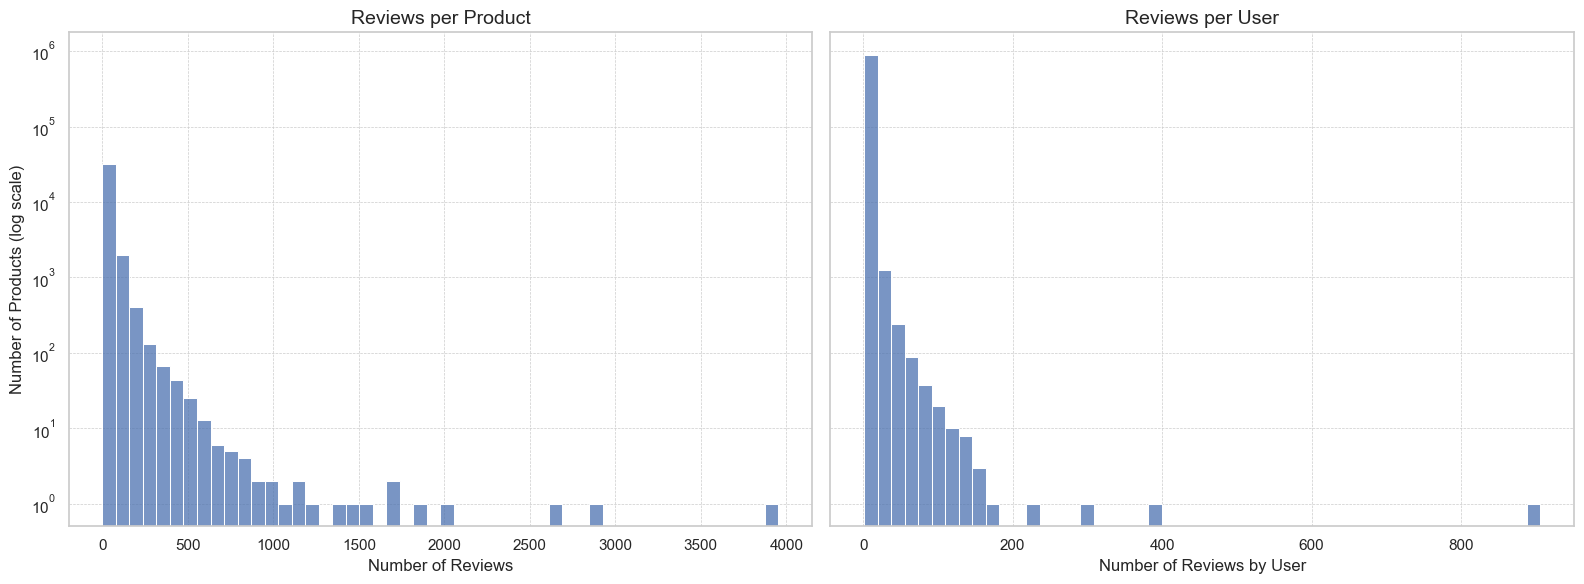

In [15]:
# Here we plot the user and product distributions: 

# Compute reviews per product
asin_review_counts = df['asin'].value_counts()

# Compute reviews per user
user_review_counts = df['user_id'].value_counts()
filtered_user_counts = user_review_counts[user_review_counts <= 10000]

# Plot styling
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# --- Plot 1: Reviews per Product ---
sns.histplot(
    asin_review_counts,
    bins=50,
    binrange=(0, asin_review_counts.max()),
    color="#4C72B0",
    edgecolor='white',
    ax=axes[0]
)
axes[0].set_yscale("log")
axes[0].set_title("Reviews per Product", fontsize=14)
axes[0].set_xlabel("Number of Reviews", fontsize=12)
axes[0].set_ylabel("Number of Products (log scale)", fontsize=12)
axes[0].grid(True, linestyle='--', linewidth=0.5)

# --- Plot 2: Reviews per User (Filtered) ---
sns.histplot(
    filtered_user_counts,
    bins=50,
    color="#4C72B0",
    edgecolor='white',
    ax=axes[1]
)
axes[1].set_yscale("log")
axes[1].set_title("Reviews per User", fontsize=14)
axes[1].set_xlabel("Number of Reviews by User", fontsize=12)
axes[1].set_ylabel("")  # Shared y-axis already labeled
axes[1].grid(True, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

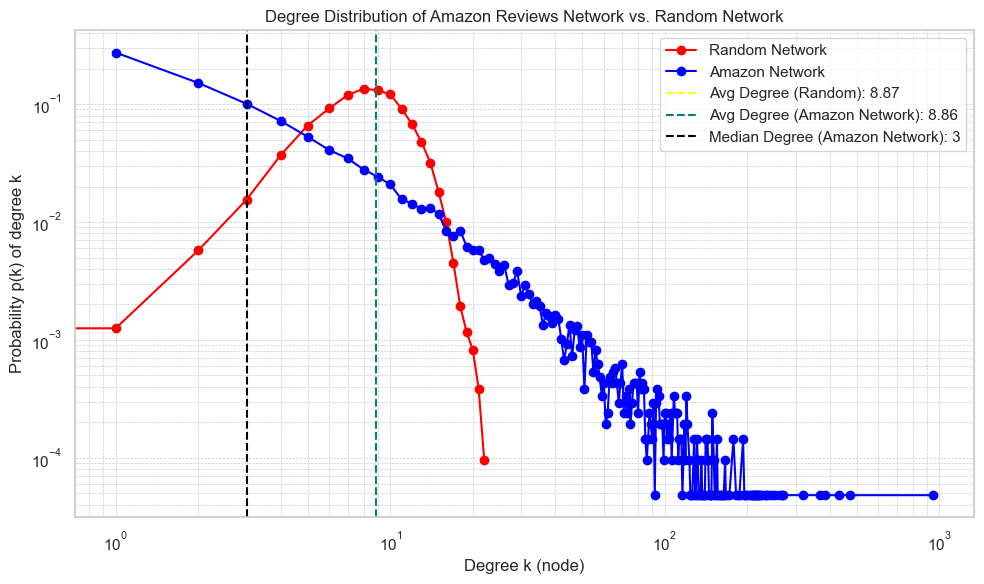

In [16]:
# Plot made to resemble the style in the course notes :::
# This plot shows us the degree distribution with a comparison to a random graph

G_real = G_filtered

# --- Step 2: Generate a random graph for comparison
n = G_real.number_of_nodes()
p = (2 * G_real.number_of_edges()) / (n * (n - 1))  # match average degree
G_random = nx.erdos_renyi_graph(n, p)

# --- Step 3: Get degree distributions
def degree_distribution(graph):
    degrees = [d for n, d in graph.degree()]
    hist = np.bincount(degrees)
    pk = hist / sum(hist)
    return np.nonzero(pk)[0], pk[pk > 0]  # degrees, probabilities

deg_real, pk_real = degree_distribution(G_real)
deg_rand, pk_rand = degree_distribution(G_random)

# --- Step 4: Plotting
plt.figure(figsize=(10, 6))
plt.loglog(deg_rand, pk_rand, 'o-', color='red', label="Random Network")
plt.loglog(deg_real, pk_real, 'o-', color='blue', label="Amazon Network")

# --- Step 5: Annotate with average/median degree
avg_deg_real = np.mean([d for _, d in G_real.degree()])
med_deg_real = np.median([d for _, d in G_real.degree()])
avg_deg_rand = np.mean([d for _, d in G_random.degree()])

# Add vertical lines
plt.axvline(avg_deg_rand, linestyle="--", color="yellow", label=f"Avg Degree (Random): {avg_deg_rand:.2f}")
plt.axvline(avg_deg_real, linestyle="--", color="teal", label=f"Avg Degree (Amazon Network): {avg_deg_real:.2f}")
plt.axvline(med_deg_real, linestyle="--", color="black", label=f"Median Degree (Amazon Network): {med_deg_real:.0f}")

# Labels and legend
plt.xlabel("Degree k (node)")
plt.ylabel("Probability p(k) of degree k")
plt.title("Degree Distribution of Amazon Reviews Network vs. Random Network")
plt.legend()
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Using equation 3.2 from the [Network Science Book](https://networksciencebook.com/chapter/3) we can calculate p, and get k using built in functions. These are used to create the degree distribution graph above. We see the power law distribution by the linear looking nature of the distributon of the reviewer network. The random network in contrast has a bell shape like curve, so no heavy right tail and less variance in the degree distribution. This is a characteristic of the binomial distribution seen in the construction of the "Erdos Renyi" graph (which was used here as the built in function erdos_renyi()).

These extreme right-tail nodes are telltale signs of the small world property as we will discuss further below:

In [17]:
# Code morphed from previous assignments:
# Calculating the clustering coefficients
# This shows clear evidence of the small world property!

# Step 1: Extract giant component of real network
largest_cc = max(nx.connected_components(G_filtered), key=len)
G_giant = G_filtered.subgraph(largest_cc).copy()

# Step 2: Generate a random network with same size and edge count
n = G_giant.number_of_nodes()
m = G_giant.number_of_edges()
p = (2 * m) / (n * (n - 1))
G_random = nx.erdos_renyi_graph(n, p)

# Step 3: Approximate average path length (sampling)
# Adapted from assignment to speed up computation
def approximate_avg_path_length(graph, samples=10000):
    nodes = list(graph.nodes())
    total_length = 0
    valid_samples = 0
    for _ in range(samples):
        u, v = np.random.choice(nodes, 2, replace=False)
        try:
            length = nx.shortest_path_length(graph, source=u, target=v)
            total_length += length
            valid_samples += 1
        except nx.NetworkXNoPath:
            continue
    return total_length / valid_samples if valid_samples > 0 else float('inf')

# Step 4: Compute metrics
real_path = approximate_avg_path_length(G_giant)
rand_path = approximate_avg_path_length(G_random)
real_clustering = nx.average_clustering(G_giant)
rand_clustering = nx.average_clustering(G_random)

# Step 5: Print comparison
print("=== Small-World Property Comparison ===")
print(f"Approx. Avg Path Length (Amazon Network): {real_path:.4f}")
print(f"Approx. Avg Path Length (Random Network): {rand_path:.4f}")
print()
print(f"Clustering Coefficient (Amazon Network):  {real_clustering:.4f}")
print(f"Clustering Coefficient (Random Network):  {rand_clustering:.4f}")

=== Small-World Property Comparison ===
Approx. Avg Path Length (Amazon Network): 5.1278
Approx. Avg Path Length (Random Network): 4.6453

Clustering Coefficient (Amazon Network):  0.1794
Clustering Coefficient (Random Network):  0.0006


In [18]:
n = G_filtered.number_of_nodes()
m = G_filtered.number_of_edges()

p_actual = (2 * m) / (n * (n - 1))
p_critical = 1 / n
p_connected = np.log(n) / n

print("=== Connectivity Analysis ===")
print(f"Number of nodes (n):             {n}")
print(f"Number of edges (m):             {m}")
print(f"Actual edge probability (p):     {p_actual:.6f}")
print(f"Critical threshold (1/n):        {p_critical:.6f}")
print(f"Connected threshold (log(n)/n):  {p_connected:.6f}")
print()
print(f"Giant Component Exists?          {p_actual > p_critical}")
print(f"Graph Likely Fully Connected?    {p_actual > p_connected}")

=== Connectivity Analysis ===
Number of nodes (n):             20711
Number of edges (m):             91728
Actual edge probability (p):     0.000428
Critical threshold (1/n):        0.000048
Connected threshold (log(n)/n):  0.000480

Giant Component Exists?          True
Graph Likely Fully Connected?    False


Supporting explanation is done on the website. To be more concrete we've used the network theory with the following formulas:

A small-world network is one that has:
- **High clustering** (nodes form tight communities)
- **Short average path lengths** (any two nodes can be reached in a small number of steps)

The clustering coefficient is given:

$$
C = \frac{1}{n} \sum_{v \in V} \frac{2e_v}{k_v(k_v - 1)}
$$

Where:
- \( k_v \): degree of node \( v \)
- \( e_v \): number of edges between neighbors of \( v \)

We compute the edge probability as:

$$
p = \frac{2m}{n(n - 1)}
$$

And compare it to the two ER thresholds:
- **Giant component threshold**:  
  $$
  p_{\text{critical}} = \frac{1}{n}
  $$

- **Connectedness threshold**:  
  $$
  p_{\text{connected}} = \frac{\log n}{n}
  $$

To summarize, it's clear that the network falls into the "supercritical" regime. There is clear evidence of the small world property, as is expected with natural networks. Additionally, we demonstrate how it differs from the random network that lacks the same clustering coefficient. 

### Community Analysis

In the first part, we are using the Louvain algorithm to find graph communities. We will filter for communities larger thatn 100 nodes as our baseline, then look more closely at some of the more interesting ones. 



In [19]:
with open("network_filtered.json", "r") as f:
    graph_data = json.load(f)

Graph = json_graph.node_link_graph(graph_data)

print(f"Filtered Graph: {Graph.number_of_nodes()} nodes, {Graph.number_of_edges()} edges")

Filtered Graph: 20711 nodes, 91728 edges


/Users/sadsa/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/NUS/24 25/24 25 Sem 2/Computational social science/Project Assignment/.venv/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


In [ ]:
# Using random state 100, we've also set np.random to state 100. 
# In spite of this we've noticed that the partitioning may change when the code is run
# multiple times. You may get slightly different results as compared to what we have
# in the project. 

partition = community_louvain.best_partition(Graph, random_state=100)

In [ ]:
# Lets filter away tiny communities and put it into neat dictionaries for easier access:

communities = defaultdict(list)
for node, comm_id in partition.items():
    communities[comm_id].append(node)

communities = defaultdict(list, {
    k: v for k, v in communities.items() if len(v) > 100 # keep only the communities with more than 100 members
})

for comm_id, members in communities.items():
    print(f"Community {comm_id}: {members}")

In [ ]:
# Community sizes + ID's
def print_community_sizes(community_dict):
    for community_id, asin_list in community_dict.items():
        print(f"Community {community_id}: {len(asin_list)} items")

print_community_sizes(communities)

In [ ]:
# Save to json so other notebooks can open it in a convenient way:
with open('communities.json', 'w') as file:
    json.dump(communities, file, indent=4)

In [ ]:
# open the json file to see communities (for later use)
with open("communities.json") as f:
    communities = json.load(f)
    communities = defaultdict(list, {k: v for k, v in communities.items() if len(v) > 100}) 
    communities = {int(k): v for k, v in communities.items()} # convert the keys to int so we can index later

In [ ]:
# this is the list of communities that we have found are interesting
print(list(communities.keys()))

[44, 1, 2, 3, 5, 147, 8, 9, 10, 11, 13, 17, 37]


#### Network visualization

In [ ]:
community_colors = {
    0: "#FF0000",  # Red
    1: "#0000FF",  # Blue
    2: "#00FF00",  # Green
    3: "#FF00FF",  # Magenta
    4: "#FFFF00",  # Yellow
    5: "#00FFFF",  # Cyan
    6: "#FFA500",  # Orange
    7: "#800080",  # Purple
    8: "#008000",  # Dark Green
    9: "#FF4500",  # Orange-Red
    10: "#4169E1",  # Royal Blue
    11: "#32CD32",  # Lime Green
    12: "#8A2BE2",  # Blue Violet
    13: "#FF6347",  # Tomato
}

# this is using parent asin, but easier to just write asin
colour_idx = 0
for comm_id, asin_list in communities.items(): 
    if len(asin_list) > 100:
        print(comm_id, community_colors[colour_idx])
        for asin in asin_list:
            G_filtered.nodes[asin]["group"] = comm_id
            G_filtered.nodes[asin]['color'] = community_colors[colour_idx]
        colour_idx += 1
    else:
        G_filtered.nodes[asin]["group"] = 100
        G_filtered.nodes[asin]['color'] = "#000000"
for node in G_filtered.nodes:
    if "group" not in G_filtered.nodes[node]:
        G_filtered.nodes[node]["group"] = 100
        G_filtered.nodes[asin]['color'] = "#000000"
        nw.visualize(
    Graph,
    config={
        'zoom': 0.6,
        'nodeCharge': -50,
        'gravity': 0.25
    }
)

44 #FF0000
1 #0000FF
2 #00FF00
3 #FF00FF
5 #FFFF00
147 #00FFFF
8 #FFA500
9 #800080
10 #008000
11 #FF4500
13 #4169E1
17 #32CD32
37 #8A2BE2


/Users/sadsa/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/NUS/24 25/24 25 Sem 2/Computational social science/Project Assignment/.venv/lib/python3.10/site-packages/networkx/readwrite/json_graph/node_link.py:142: FutureWarning: 
The default value will be `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_data(G, edges="links") to preserve current behavior, or
  nx.node_link_data(G, edges="edges") for forward compatibility.
  warnings.warn(


Below are a range of functions in order to preprocess and clean up the dataset for analysis. In the first step we will show how we extract a genre whitelist from the categories column:

In [49]:
#This function parses the categories column, we will use this later to construct a whitelist
#of terms to catch genres:
def extract_unique_category_terms(df, column='categories'):
    all_terms = set()
    
    for raw_entry in df[column].dropna():
        try:
            # If the entry is stringified like a list, we safely convert it back to a list
            parsed = eval(raw_entry)
            if isinstance(parsed, list):
                all_terms.update(parsed)
        except Exception as e:
            print(f"Error parsing entry: {raw_entry}, Error: {e}")
    
    return all_terms

all_category_terms = extract_unique_category_terms(df) #Every unique term in categories

In [50]:
#We will print these. After printing we insert every word into an LLM
# To parse the valid genre names and cut through the noise. 
# In addition - manual overview and selection has been done to get the final whitelist
print(all_category_terms)

{'DVD', 'Stephen Lynch', 'Universal Studios Featured Deals', '3-6 Years', 'Action & Adventure', 'Optimistic', 'Foreign Films', 'DTS', 'Kids', 'Arts & Entertainment', 'Easygoing', 'Holiday, Billie', 'All Titles', 'General', 'Imaginative', 'Biting', 'All MGM Titles', 'The Comedy Central Store', 'DreamWorks', 'Upbeat', 'King, B.B.', 'Bleak', 'Biography', 'Spotlight Deals', 'Touching', 'Tenacious D', 'DC Universe Animated Original Movies', 'Foreign Spotlight', 'Boxed Sets', 'Miramax Home Entertainment', 'Feel-good', 'Sci-Fi Series & Sequels', 'Rieu, Andre', 'Genre for Featured Categories', 'Timeless Holiday Favorites', 'Pink Floyd', 'Joel, Billy', 'Dune', 'X-Men', 'Fitness', 'Sony Pictures Classics', 'All Sci Fi Channel Shows', 'Ballet & Dance', 'Dylan, Bob', 'Inspiring', 'Slasher', 'Exotic', 'Lionsgate DVDs Under $10', 'Reality TV', 'Scary', 'Yoga Journal', 'Historical', 'Golden Globe Central', 'Warner DVD & Blu-ray Deals', 'Emmy Central', 'Special Interests', 'Featured Categories', 'Jewi

In [51]:
#Helper function to speed up the next code block
def build_asin_to_categories(df):
    """Preprocess the dataframe to create a fast lookup dictionary."""
    asin_to_categories = {}
    for _, row in df.iterrows():
        asin = row['parent_asin']
        try:
            categories = ast.literal_eval(row['categories']) if pd.notna(row['categories']) else []
        except (ValueError, SyntaxError, TypeError):
            categories = []
        asin_to_categories[asin] = categories
    return asin_to_categories

asin_to_categories = build_asin_to_categories(df)

In [54]:
# Using an LLM to parse for genre-like terms + manual curation to get the list:
valid_genres = [
    'action', 'adventure', 'comedy', 'drama', 'fantasy', 'sci-fi', 'science fiction',
    'horror', 'thriller', 'romance', 'mystery', 'animation', 'documentary', 'family', 
    'musicals', 'biography', 'historical', 'crime', 'music', 'war', 'western', 'kids', 
    'educational', 'reality', 'anime', 'fitness', 'yoga', 'exercise', 'sports', 
]

# This function counts the number of matches from valid_genres in the categories column
# for a certain community:
def get_top_genres_for_community(community_asins, asin_to_categories, top_n):
    genre_counter = Counter()

    for asin in community_asins:
        categories = asin_to_categories.get(asin, [])
        for cat in categories:
            cat_lower = cat.lower()
            for genre in valid_genres:
                if genre in cat_lower:
                    genre_counter[genre] += 1

    return dict(genre_counter.most_common(top_n))

# Try it out here by putting in a community id from the list :[44, 1, 2, 3, 5, 147, 8, 9, 10, 11, 13, 17, 37]
# We can also use this code to get some future plots of the actual statistics
# If that makes sense, like make a for loop for each id.
community_id = 37
asin_list = communities[community_id]
top_genres = get_top_genres_for_community(asin_list, asin_to_categories, 10)
print(top_genres)

{'anime': 37, 'action': 7, 'adventure': 7, 'science fiction': 6, 'fantasy': 3, 'animation': 3, 'family': 3, 'drama': 1, 'comedy': 1, 'kids': 1}


With the functions above, we now have a framework to count genre frequencies in each community. This provides a dictionary with genre + frequency for every match in the whitelist.

In [55]:
# We also need a function to extract images for the plotting function:

# Load the metadata dataset that contains image URLs
meta_df = pd.read_csv('meta_Movies_and_TV_Full.csv')

asin_to_image = {}

for _, row in meta_df.iterrows():
    asin = row['parent_asin']
    image_data = row['images']
    
    # Check if the image_data is a list of dictionaries
    if isinstance(image_data, str):
        try:
            image_urls = eval(image_data)
            for image in image_urls:
                if isinstance(image, dict):  # Check if it's a dictionary
                    if 'large' in image:
                        asin_to_image[asin] = image['large']
                        break
                    elif '360w' in image:
                        asin_to_image[asin] = 'no image' #These images aren't very good so left out
                        break
        except (ValueError, SyntaxError, TypeError):
            continue

/var/folders/7b/snpms3c90nqg721sdk5lczdw0000gn/T/ipykernel_69489/629391406.py:4: DtypeWarning: Columns (2,4,7,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  meta_df = pd.read_csv('meta_Movies_and_TV_Full.csv')


In [56]:
# We can grab the image URL for any ASIN here, only works for "Movies", Prime Video 
# Doesn't have proper images but random stills from the movie, left out for now.
# You can feel free to change it in the above function and see how the plots
# Change in the code below. Or you can test it right here:

asin_example = 'B001JV5BF8'
image_url = asin_to_image.get(asin_example, 'Invalid Key')
print(f"Image URL for ASIN {asin_example}: {image_url}")

Image URL for ASIN B001JV5BF8: https://m.media-amazon.com/images/I/515qo5iCUzL.jpg


Here comes the first major roadblock: The movie titles themselves are not standardized in the dataset. Meaning, different versions of the same movie come up with different formats (Blu Ray/DVD/Digital), and there's the issue of boxed sets, combo formats, and sequels with otherwise identical titles. So, in order to get a standardized baseline to use when selecting the top movie picks in each community we need to use regular expressions to try and filter out all the extraneous noise. 

When we plot the titles themselves we will use the "real" titles. But at the comparison stage regex are used to avoid duplicate movies coming up in the same ranking. It will just pick the top movie and then reject it's regex'ed duplicate if it's found in the same community. This just gives a nicer overview.

For comparison we remove:
 * [DVD], [Blu-ray] etc.
 * (Special Edition) etc.
 * Strip out all punctuation
 * Remove whitespace around leading/trailing movie titles

You can look at the specific functionality in the code just below:

In [57]:
# This code uses regular expressions to filter out titles in order to avoid duplicates
# In the get_top_titles functions:
def normalize_title(title):
    if not isinstance(title, str):
        return ''
    title = title.lower()
    
    # Keep part after comma if it exists and the part after is short (likely the title)
    if ',' in title:
        parts = title.split(',')
        if len(parts[1].strip().split()) <= 4:
            title = parts[1]
    
    title = re.sub(r'\[.*?\]', '', title)              # remove [DVD], [Blu-ray], etc.
    title = re.sub(r'\(.*?edition\)', '', title)       # remove (Special Edition), etc.
    title = re.sub(r'\(.*?format\)', '', title)        # remove other bracketed formats
    title = re.sub(r'[^a-z0-9\s]', '', title)          # remove punctuation
    title = re.sub(r'\s+', ' ', title).strip()         # normalize whitespace
    return title

# Simply returns the top titles, based on the rating_number WITHOUT the genre filter:
# Probably not going to use this function much, but it's nice to have.
def get_top_titles_for_community(community_asins, df, top_n=10):
    df['rating_number'] = df['rating_number'].apply(pd.to_numeric, errors='coerce')
    matching_rows = df[df['parent_asin'].isin(community_asins)]
    
    deduped = matching_rows.sort_values('rating_number', ascending=False).drop_duplicates('parent_asin')
    
    top_rows = deduped.sort_values('rating_number', ascending=False)
    top_rows = top_rows[top_rows['movie_title'].notna()]
    
    seen = set()
    unique_top_titles = []
    
    for _, row in top_rows.iterrows():
        norm_title = normalize_title(row['movie_title'])
        if norm_title not in seen:
            seen.add(norm_title)
            unique_top_titles.append((row['movie_title'], row['rating_number']))
        if len(unique_top_titles) >= top_n:
            break

    return unique_top_titles


In [58]:
# Test the function without filter here:
community_id = 44
asin_list = communities[community_id]
top_titles = get_top_titles_for_community(asin_list, df)
for t in top_titles:
    print(t)

('The Green Mile (Single Disc Edition)', 14610.0)
('Yoga for Beginners 8 Yoga Video Routines for Beginners. Includes Gentle Yoga Workouts to Increase Strength & Flexibility', 5137.0)
("Gentle Yoga: 7 Beginning Yoga Practices for Mid-life (40's - 70's) including AM Energy, PM Relaxation, Improving Balance, Relief from Desk Work, Core Strength, and more.", 4474.0)
('Jillian Michaels: Yoga Meltdown [DVD]', 3647.0)
('Zumba Fitness Total Body Transformation System DVD Set', 3233.0)
('Balance & Strength Exercises for Seniors: 9 Practices, with Traditional Exercises, and Modified Tai Chi, Yoga & Dance Based Movements.', 3206.0)
('Jillian Michaels: Banish Fat Boost Metabolism', 3001.0)
('Anne Of Green Gables - The Sequel [DVD]', 2842.0)
('Yoga for Seniors with Jane Adams (2nd edition): Improve Balance, Strength & Flexibility with Gentle Senior Yoga, now with 3 complete practices.', 2817.0)
('Tai Chi For Beginners DVD: 8 Tai Chi Beginner Video Workouts. Easy Tai Chi Routines. includes Gentle Ta

In [59]:
# This code block filters the top tiles WITH the top genre filter to get a better
# overview of the type of movie in a community. Why? Because the communities generally
# Share genres like action/drama so the same types of movies will otherwise dominate
# in every communities top hits.

def get_top_titles_by_genre_for_community(community_asins, df, asin_to_categories, top_n=10):
    # First get the top genre for this community
    top_genres = get_top_genres_for_community(community_asins, asin_to_categories, 1)
    top_genre = next(iter(top_genres.keys()))
    
    # Get matching rows for this community
    matching_rows = df[df['parent_asin'].isin(community_asins)]
    
    # Filter rows that have the top genre in their categories
    filtered_rows = []
    for _, row in matching_rows.iterrows():
        categories = asin_to_categories.get(row['parent_asin'], [])
        categories_lower = [cat.lower() for cat in categories]
        if any(top_genre in cat for cat in categories_lower):
            filtered_rows.append(row)
    
    # Create a DataFrame from filtered rows
    filtered_df = pd.DataFrame(filtered_rows)
    
    # Deduplicate and sort by rating_number
    deduped = filtered_df.sort_values('rating_number', ascending=False).drop_duplicates('parent_asin')
    top_rows = deduped.sort_values('rating_number', ascending=False)
    top_rows = top_rows[top_rows['movie_title'].notna()]
    
    # Get unique titles
    seen = set()
    unique_top_titles = []
    
    for _, row in top_rows.iterrows():
        norm_title = normalize_title(row['movie_title'])
        if norm_title not in seen:
            seen.add(norm_title)
            unique_top_titles.append((row['movie_title'], row['rating_number']))
        if len(unique_top_titles) >= top_n:
            break

    return unique_top_titles, top_genre

In [60]:
# Here you can test the genre filtered version:
# This is the one we use in the plotting function below as well
# And the substrate to the project analysis.
community_id = 44
asin_list = communities[community_id]
top_titles, top_genre = get_top_titles_by_genre_for_community(asin_list, df, asin_to_categories, 20)

print(f"Top {top_genre} movies in community {community_id}:")
for title, rating_count in top_titles:
    print(f"  > {title} (Ratings: {rating_count})")

Top fitness movies in community 44:
  > Yoga for Beginners 8 Yoga Video Routines for Beginners. Includes Gentle Yoga Workouts to Increase Strength & Flexibility (Ratings: 5137.0)
  > Gentle Yoga: 7 Beginning Yoga Practices for Mid-life (40's - 70's) including AM Energy, PM Relaxation, Improving Balance, Relief from Desk Work, Core Strength, and more. (Ratings: 4474.0)
  > Jillian Michaels: Yoga Meltdown [DVD] (Ratings: 3647.0)
  > Balance & Strength Exercises for Seniors: 9 Practices, with Traditional Exercises, and Modified Tai Chi, Yoga & Dance Based Movements. (Ratings: 3206.0)
  > Jillian Michaels: Banish Fat Boost Metabolism (Ratings: 3001.0)
  > Yoga for Seniors with Jane Adams (2nd edition): Improve Balance, Strength & Flexibility with Gentle Senior Yoga, now with 3 complete practices. (Ratings: 2817.0)
  > Tai Chi For Beginners DVD: 8 Tai Chi Beginner Video Workouts. Easy Tai Chi Routines. includes Gentle Tai Chi for Seniors to increase Strength, Balance & Flexibility (Ratings:

In [61]:
def plot_community_summary(
    comm_id,
    communities,
    df_full,
    asin_to_image,
    get_top_titles_by_genre_for_community,
    get_top_genres_for_community,
    asin_to_categories,
    top_n_display=9,
    buffer_size=1000,
    top_n_genres=6
):
    community_asins = communities[comm_id]

    top_title_tuples, top_genre = get_top_titles_by_genre_for_community(
        community_asins=community_asins,
        df=df_full,
        asin_to_categories=asin_to_categories,
        top_n=buffer_size
    )
    top_titles = [t[0] for t in top_title_tuples]
    title_to_count = dict(top_title_tuples)

    images, titles, counts = [], [], []
    for title in top_titles:
        if len(images) == top_n_display:
            break
        row = df_full[df_full['movie_title'].str.lower() == title.lower()]
        if row.empty: continue
        asin = row.iloc[0]['asin']
        url = asin_to_image.get(asin)
        if not url or url == "no image": continue
        resp = requests.get(url, timeout=5)
        img = Image.open(BytesIO(resp.content)).resize((220, 330))
        images.append(img)
        titles.append(title)
        counts.append(title_to_count.get(title, 0))

    genre_dict = get_top_genres_for_community(
        community_asins,
        asin_to_categories,
        top_n_genres
    )
    top_genres = sorted(genre_dict.items(), key=lambda x: -x[1])

    # Plot setup
    fig = plt.figure(figsize=(10.5, 6))
    gs = fig.add_gridspec(3, 5, width_ratios=[1, 1, 1, 0.4, 1.2], wspace=0.05, hspace=0.3)

    for i, img in enumerate(images):
        ax = fig.add_subplot(gs[i // 3, i % 3])
        ax.imshow(img)
        label = f"{titles[i].capitalize()[:22]}\n({int(counts[i]):,} ratings)"
        ax.set_title(label, fontsize=8, pad=8) 
        ax.axis("off")

    axg = fig.add_subplot(gs[:, 4])
    if top_genres:
        labels, vals = zip(*top_genres)
        labels = [g.capitalize() for g in labels]
        axg.barh(labels[::-1], vals[::-1], color='skyblue')
        axg.set_xlabel("Frequency")
        axg.set_title("Top Genres")

    fig.suptitle(f"Community {comm_id} — {top_genre.capitalize()}", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


/var/folders/7b/snpms3c90nqg721sdk5lczdw0000gn/T/ipykernel_69489/3845809116.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


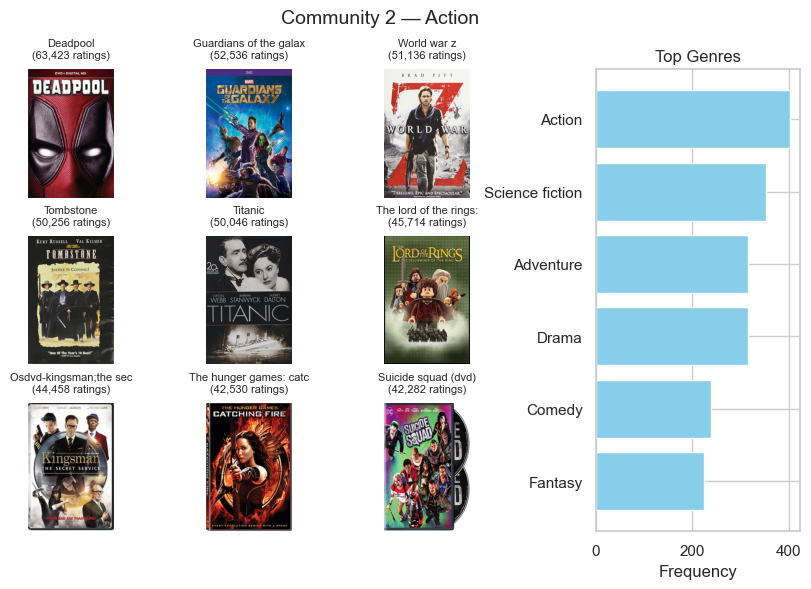

In [62]:
# Available ID's
# [44, 1, 2, 3, 5, 147, 8, 9, 10, 11, 13, 17, 37]

# Simply insert the ID here (after running all the above code) to test:
# This code ONLY picks the "Physical Movie" type, since the streaming/digital titles
# Don't have a proper product preview. This means some highly popular titles
# Wont show up here, even though they are present in the community.
plot_community_summary(
    comm_id=2,
    communities=communities,
    df_full=df,
    asin_to_image=asin_to_image,
    get_top_titles_by_genre_for_community=get_top_titles_by_genre_for_community,
    get_top_genres_for_community=get_top_genres_for_community,
    asin_to_categories=asin_to_categories
)

### Assortativity

In this section we will go over the use of assortativity. With assortativity you can track how nodes in your network tend to gather with other networks of some similar feature. It's possible to look at degree assortativity for instance. Here we are chosing dominant genre assortativity. This measures how dominant the primary genre is, within a community. Using this we get a numeric tool to support each community. We also experimented with sentiment based assortativity but found just noisy patterns. 

In [63]:
# df is just the merged dataset with genres and stuff
def extract_primary_genre(categories, valid_genres):
    for cat in categories:
        cat_lower = cat.lower()
        for genre in valid_genres:
            if genre in cat_lower:
                return genre
    return None  # no valid genre matched

asin_to_genre = {
    asin: extract_primary_genre(categories, valid_genres)
    for asin, categories in asin_to_categories.items()
    if extract_primary_genre(categories, valid_genres) is not None
}

def compute_genre_assortativity(G, asin_list, asin_to_genre):
    valid_asins = [asin for asin in asin_list if asin in asin_to_genre]
    if len(valid_asins) < 2:
        return None

    subG = G.subgraph(valid_asins).copy()

    for asin in subG.nodes:
        subG.nodes[asin]['genre'] = asin_to_genre[asin]

    return nx.attribute_assortativity_coefficient(subG, 'genre')


In [64]:
for comm_id in (communities.keys()):
    score = compute_genre_assortativity(Graph, communities[comm_id], asin_to_genre)
    if score is not None:
        print(f"Genre assortativity for community {comm_id}: {score:.4f}")
    else:
        print(f"Genre assortativity for community {comm_id}: not enough data")

Genre assortativity for community 44: 0.1435
Genre assortativity for community 1: 0.3016
Genre assortativity for community 2: 0.2109
Genre assortativity for community 3: 0.2248
Genre assortativity for community 5: 0.3242
Genre assortativity for community 147: 0.1518
Genre assortativity for community 8: 0.1350
Genre assortativity for community 9: 0.0478
Genre assortativity for community 10: 0.1085
Genre assortativity for community 11: -0.0480
Genre assortativity for community 13: 0.2306
Genre assortativity for community 17: 0.4954
Genre assortativity for community 37: 0.1555


### Centrality

Centrality measures can tell us about the globally influential nodes. Due to our community driven analysis we wanted to look at eigen centrality. Eigen centrality looks at influence based on how well connected the node is, the number of links, and how it compares to neighbouring nodes. It will pick out movies from highly connected regions of the graph that has massive influence in particular places.

Closeness is a broad score that tracks how close the node is to every other node in the network. It computes the shortest paths between the other nodes and ranks them. This measure is particularly useful to find the globally important movies that has influence on the entire network. We wanted to look at these to test the hypothesis that a few hyper ppopular movies are indeed dominating the graph. Which turns out to be the case.

On the project website we've futher specified what this means concretely for the purposes of a reccomendation algorithm. 

In [65]:
#Extract a subgraph with just the titled movies. 
valid_asins = df.dropna(subset=['movie_title'])['parent_asin'].unique().tolist()
G_with_titles = Graph.subgraph(valid_asins).copy()
print(f"Filtered Graph: {G_with_titles.number_of_nodes()} nodes, {G_with_titles.number_of_edges()} edges")

Filtered Graph: 10630 nodes, 24785 edges


In [66]:
# We are using the built in networkX functions:
closeness = nx.closeness_centrality(G_with_titles)
eigen = nx.eigenvector_centrality(G_with_titles, max_iter=1000, tol=1e-06)

In [67]:
# Lets get the top 10 movies:
def print_top_central_movies(centrality_dict, df, top_n=10, label="Centrality"):
    top_nodes = sorted(centrality_dict.items(), key=lambda x: -x[1])[:top_n]

    for asin, score in top_nodes:
        row = df[(df['parent_asin'] == asin) | (df['asin'] == asin)]
        if not row.empty and pd.notna(row.iloc[0]['movie_title']):
            title = row.iloc[0]['movie_title']
            print(f"{title} ({asin}) — {label}: {score:.4f}")

print()        
print("Closeness Scores")
print()
print_top_central_movies(closeness, df, top_n=10, label="Closeness")

print()        
print("Eigen Scores")
print()
print_top_central_movies(eigen, df, top_n=10, label="Eigenvector")


Closeness Scores

Star Wars: The Complete Saga (Episodes I-VI) (Packaging May Vary) [Blu-ray] (B003ZSJ212) — Closeness: 0.2286
Star Wars: The Force Awakens (B018FK66TU) — Closeness: 0.2240
Downton Abbey: Season 4 (B00F1BFRA6) — Closeness: 0.2204
The Avengers: The Complete Emma Peel Megaset (B00E5G03I4) — Closeness: 0.2180
The Twilight Zone: The Complete Definitive Collection (B000H5U5EE) — Closeness: 0.2143
Man of Steel (Blu-ray) (B008JFUPK8) — Closeness: 0.2113
Firefly: The Complete Series (B0000AQS0F) — Closeness: 0.2107
Batman v Superman: Dawn of Justice, Ultimate Edition (B01DEBC7Q6) — Closeness: 0.2107
Hobbit, The: The Desolation of Smaug (Special Edition) (DVD) (B00HWWUQWQ) — Closeness: 0.2104
John Carter (Two-Disc Blu-ray/DVD Combo) (B007MDB71O) — Closeness: 0.2094

Eigen Scores

Star Wars: The Complete Saga (Episodes I-VI) (Packaging May Vary) [Blu-ray] (B003ZSJ212) — Eigenvector: 0.1827
The Christmas Card (Hallmark) (B000TGUUFA) — Eigenvector: 0.1496
Star Wars: The Force Awak

### Sentiment score distribution

In [83]:
df_sentiment = pd.read_csv("Movies_and_TV_Cleaned_Sentiment.csv")

/var/folders/7b/snpms3c90nqg721sdk5lczdw0000gn/T/ipykernel_69489/3636018111.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sentiment = pd.read_csv("Movies_and_TV_Cleaned_Sentiment.csv")


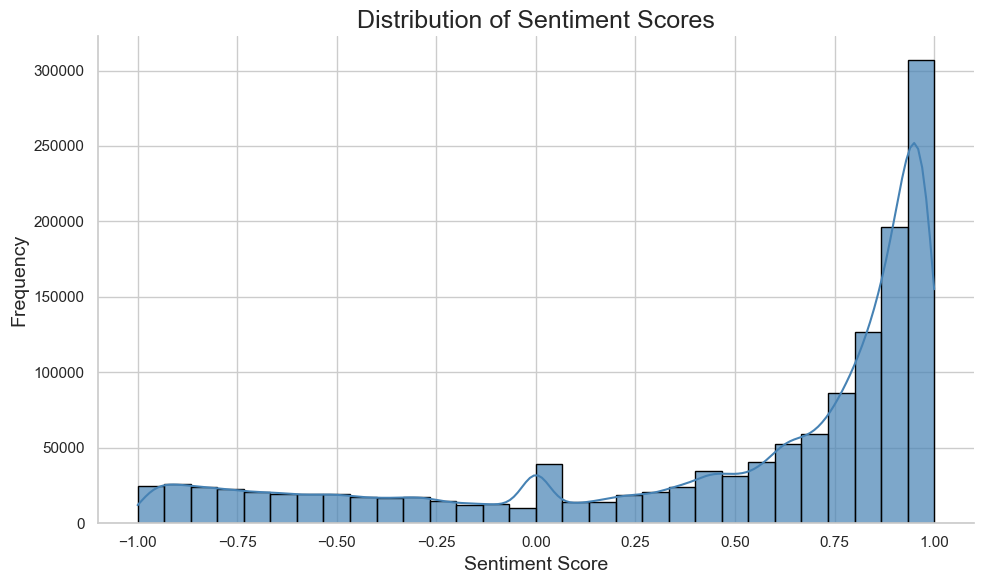

In [115]:
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment_score'], kde=True, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Sentiment Scores', fontsize=18)
plt.xlabel('Sentiment Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

### Sentiment category distribution

/var/folders/7b/snpms3c90nqg721sdk5lczdw0000gn/T/ipykernel_69489/2406645321.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colour_list)


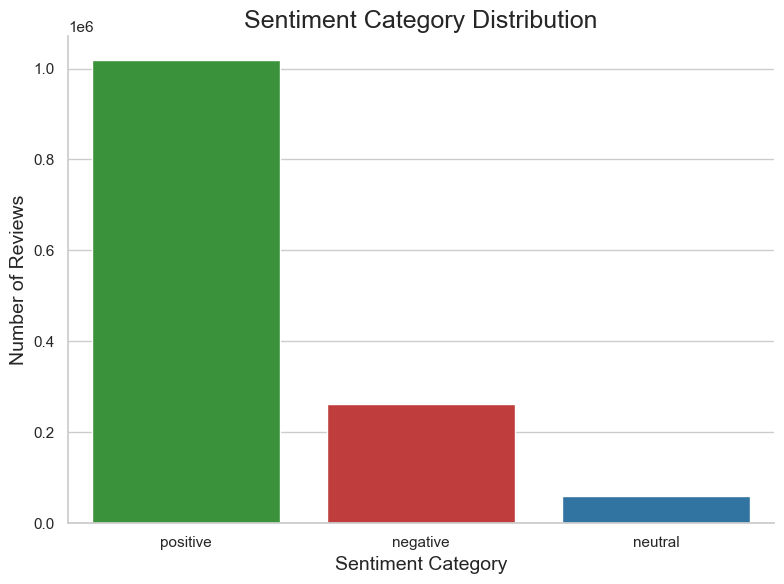

In [116]:
sentiment_counts = df['sentiment_category'].value_counts()

colours = {
    'positive': '#2ca02c',  # soft green
    'negative': '#d62728',  # soft red
    'neutral': '#1f77b4'    # soft blue
}
colour_list = [colours[sentiment] for sentiment in sentiment_counts.index]

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colour_list)
plt.title('Sentiment Category Distribution', fontsize=18)
plt.xlabel('Sentiment Category', fontsize=14)
plt.ylabel('Number of Reviews', fontsize=14)
sns.despine()
plt.tight_layout()
plt.show()

In [ ]:
sentiment_counts = df['sentiment_category'].value_counts()

colors = ['Green', 'Red', 'Blue']  # Positive, Negative, Neutral
plt.figure(figsize=(10, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=colors, hue=colors)
plt.title('Sentiment Category Distribution', fontsize=16)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.show()

### Plotting sentiment score and review count over time
This will be done for the most reviewed movies/tv shows in the selected communities.

We will first get the top title in each community and then make the plots for each top title extracted.

In [119]:
sns.set(style="whitegrid", context="talk")

focus_list = [] # getting one top title from each community
for community_id in communities.keys():
    asin_list = communities[community_id]
    top_titles = get_top_titles_for_community(asin_list, df)
    for t in top_titles:
        focus_list.append(t)
        break
focus_list

[('The Green Mile (Single Disc Edition)', 14610.0),
 ('HOCUS POCUS [Blu-ray]', 85694.0),
 ('Yellowstone: Season One', 152203.0),
 ('Dirty Dancing', 38048.0),
 ('Harry Potter and the Prisoner of Azkaban (Two-Disc Widescreen Edition)',
  58957.0),
 ("National Lampoon's Christmas Vacation [Blu-ray]", 127938.0),
 ('The Grand Tour', 89785.0),
 ('Free Guy', 103290.0),
 ('Frozen', 77609.0),
 ('Deliver Us From Evil', 6143.0),
 ('Contagion (DVD)', 58926.0),
 ('American Sniper Special Edition (DVD)', 46682.0),
 ('Masterpiece Classic: Downton Abbey, Season 3 [Blu-ray]', 38822.0)]

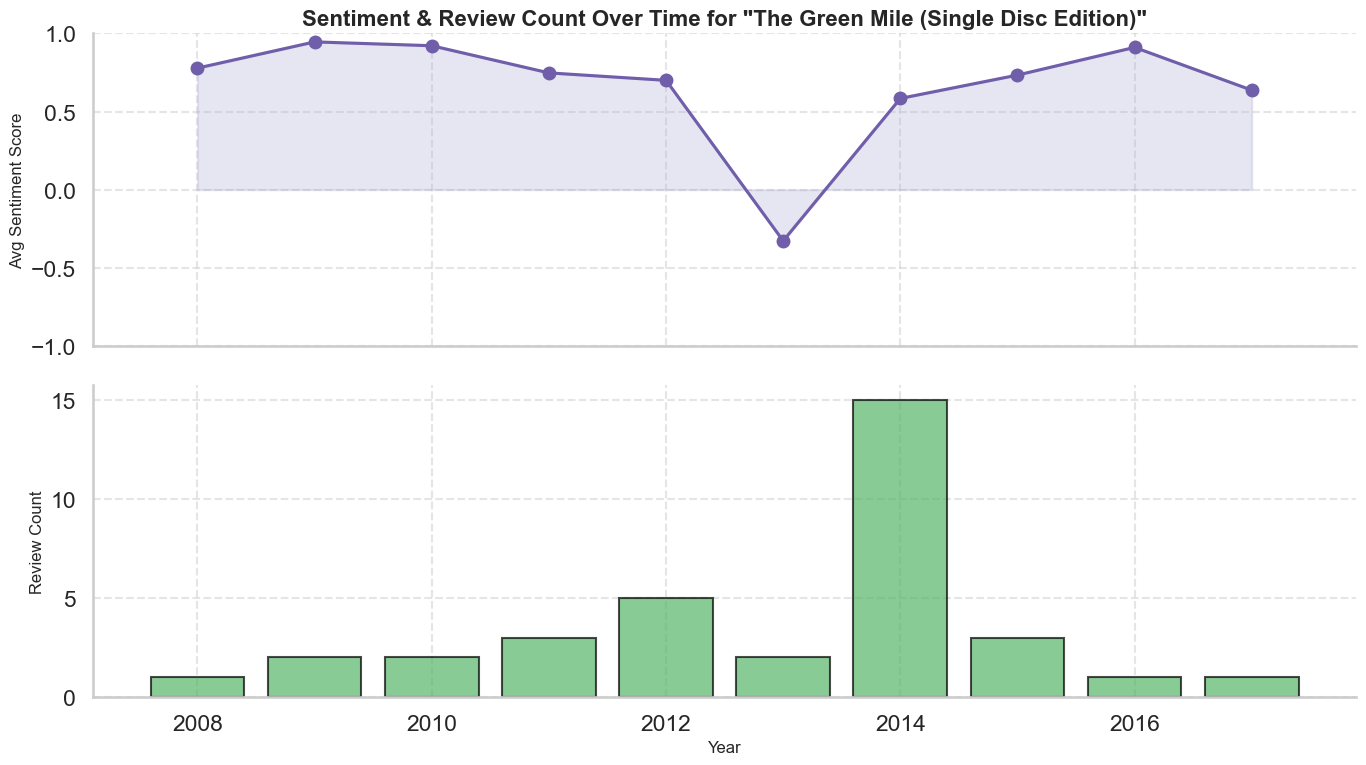

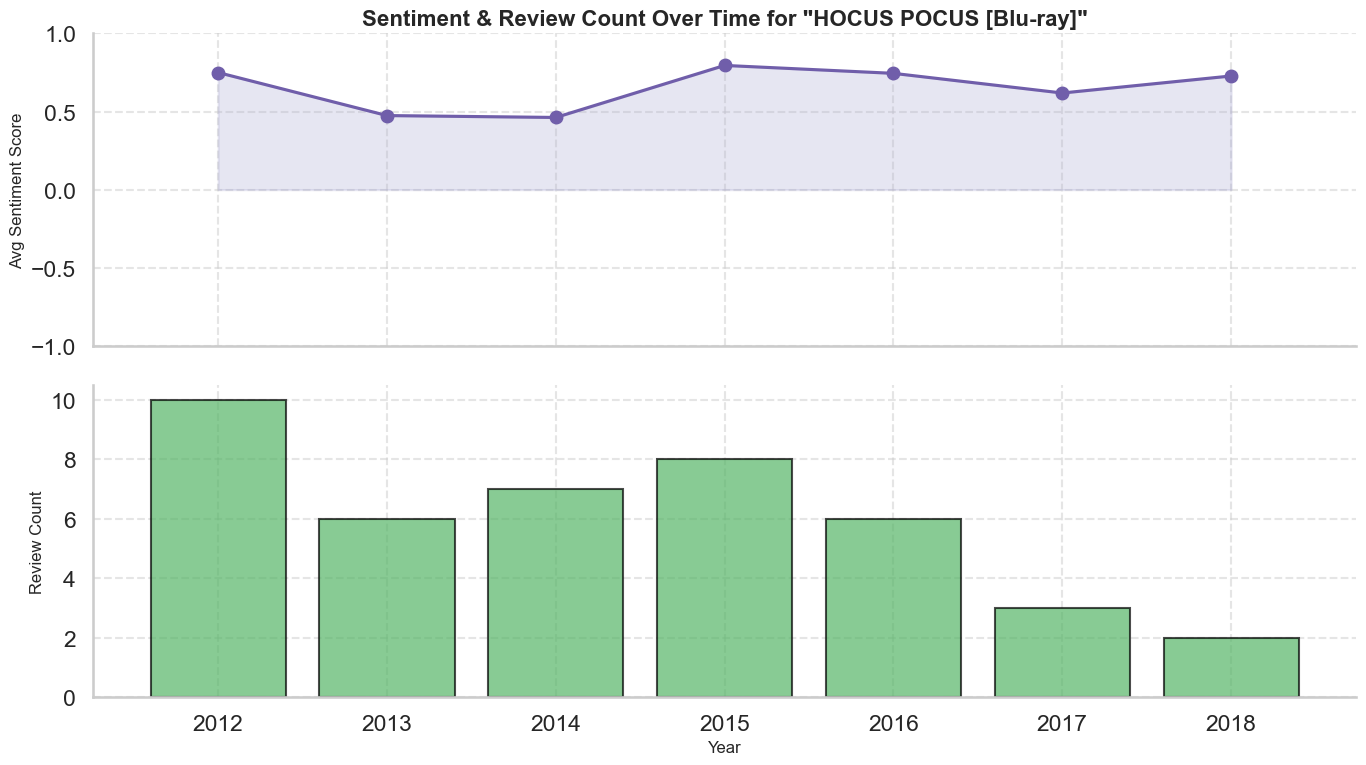

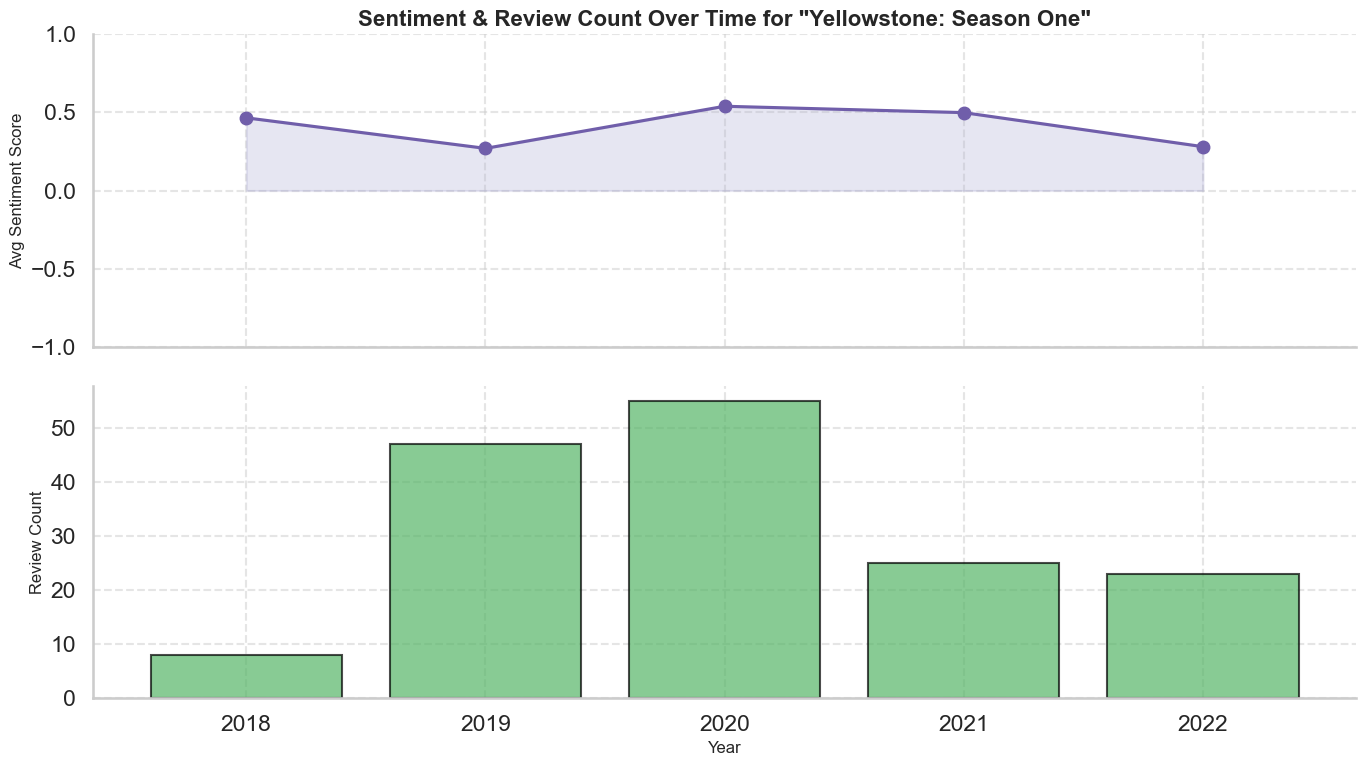

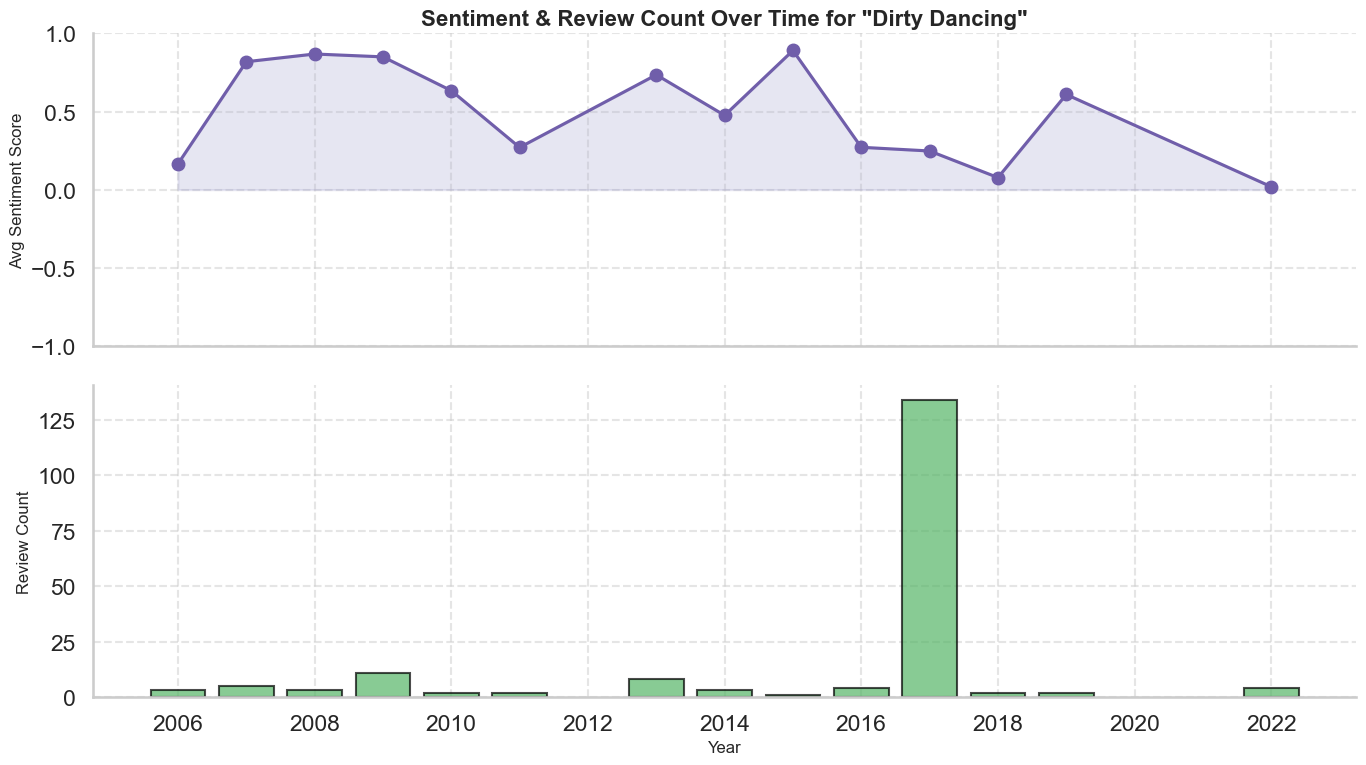

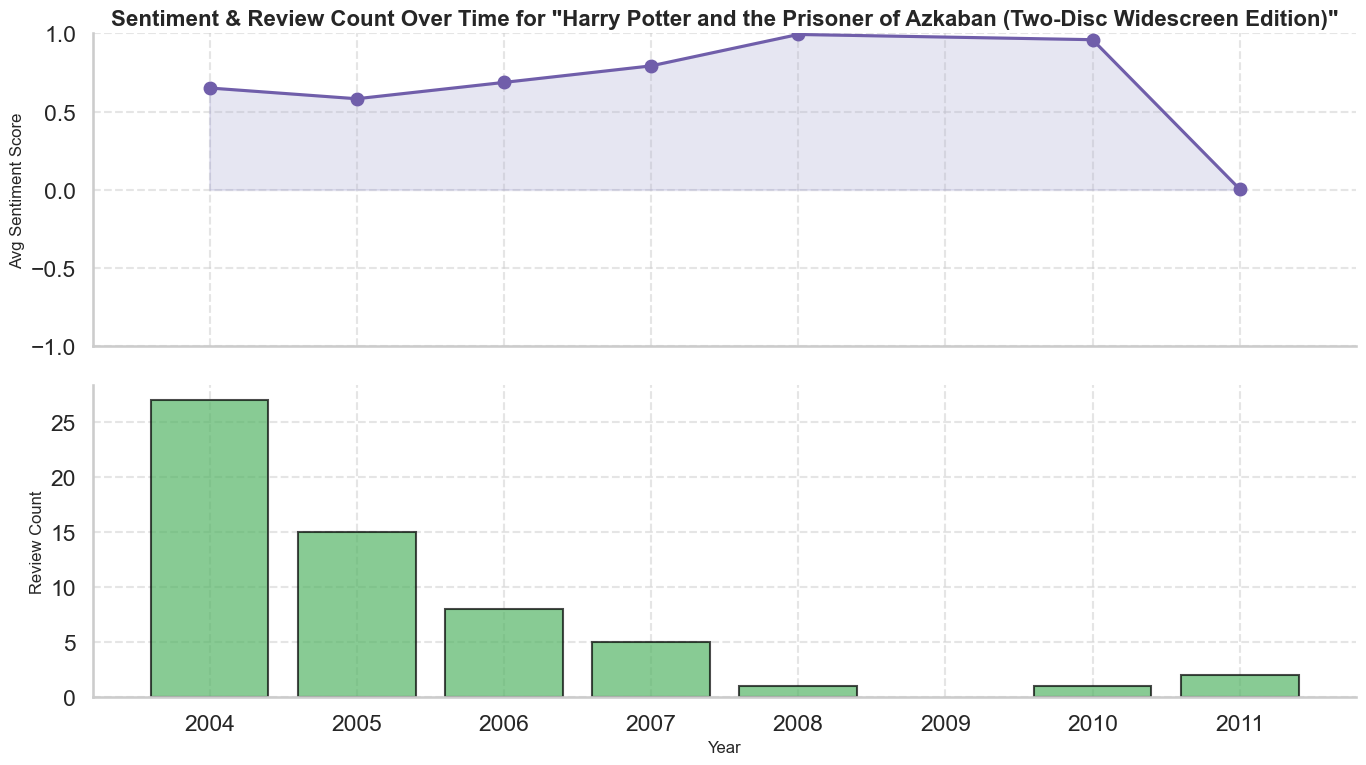

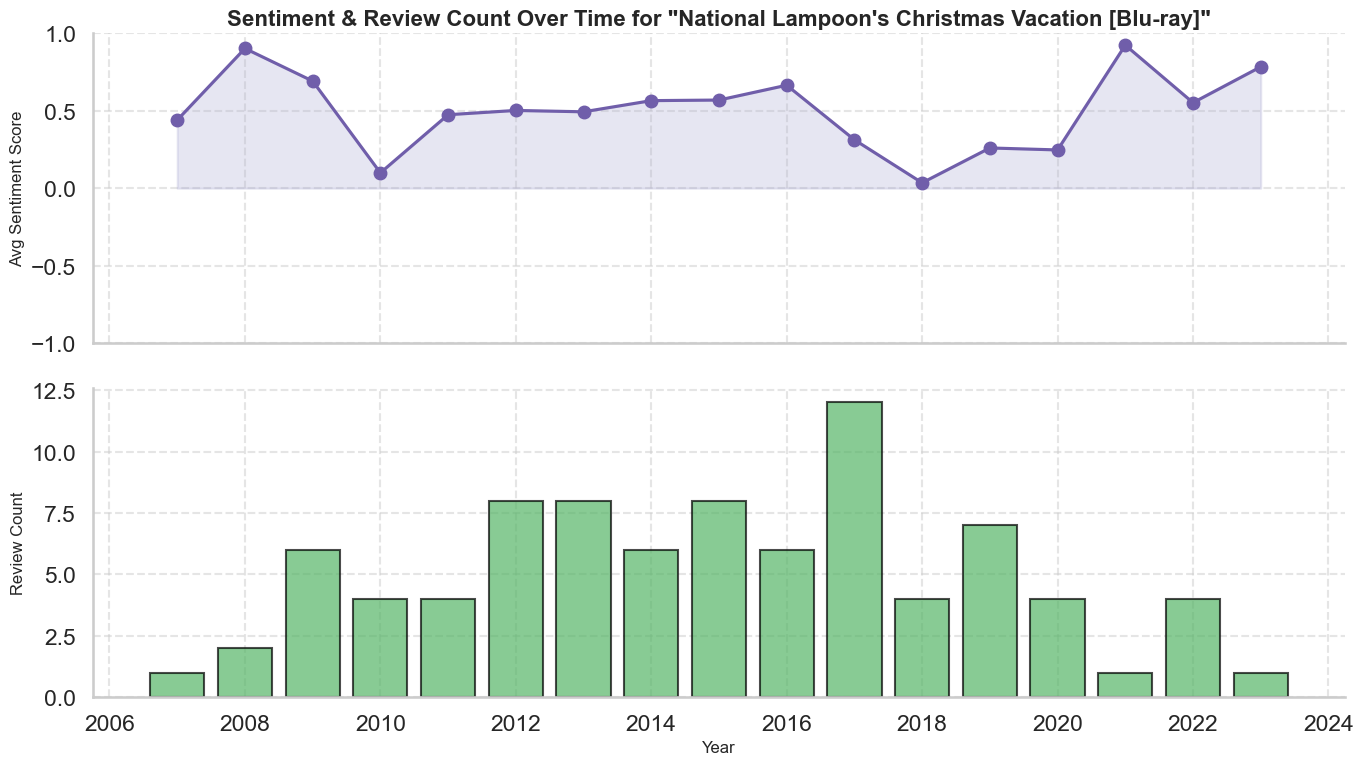

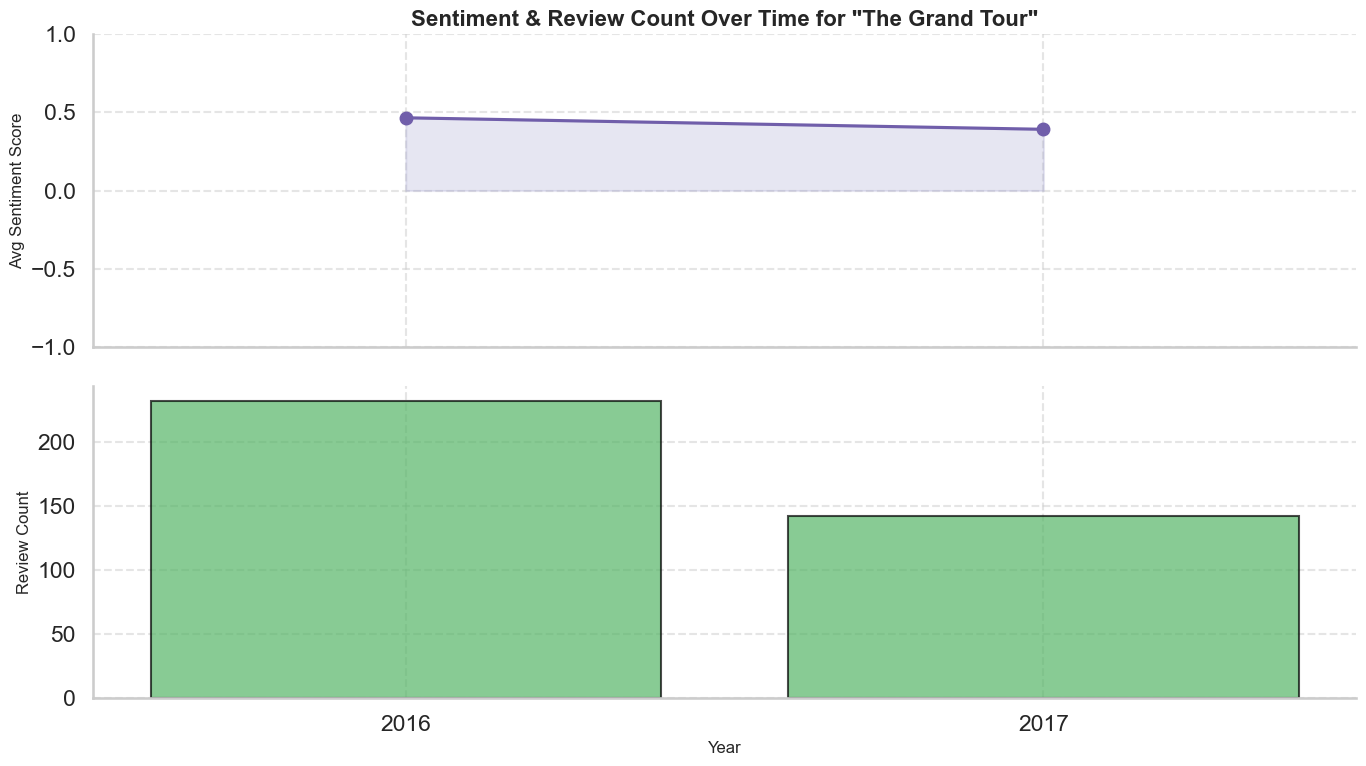

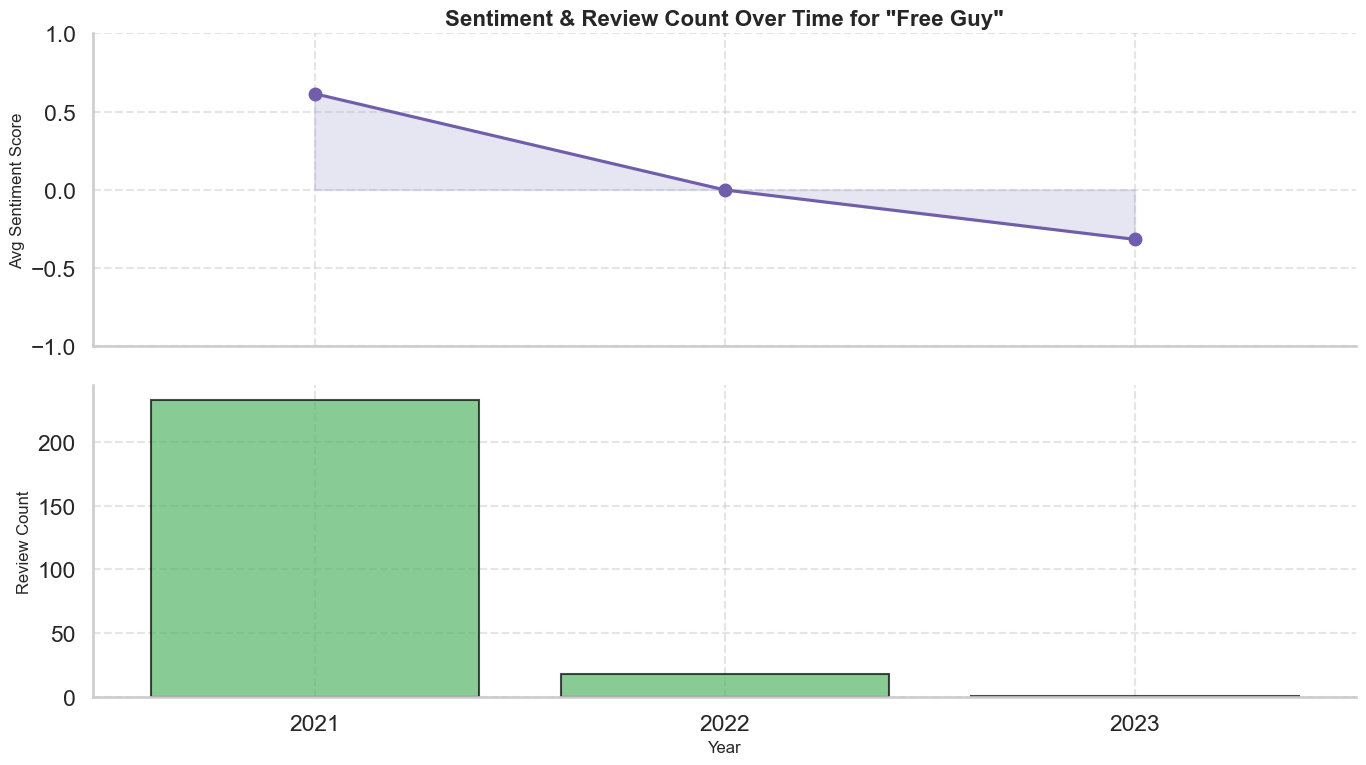

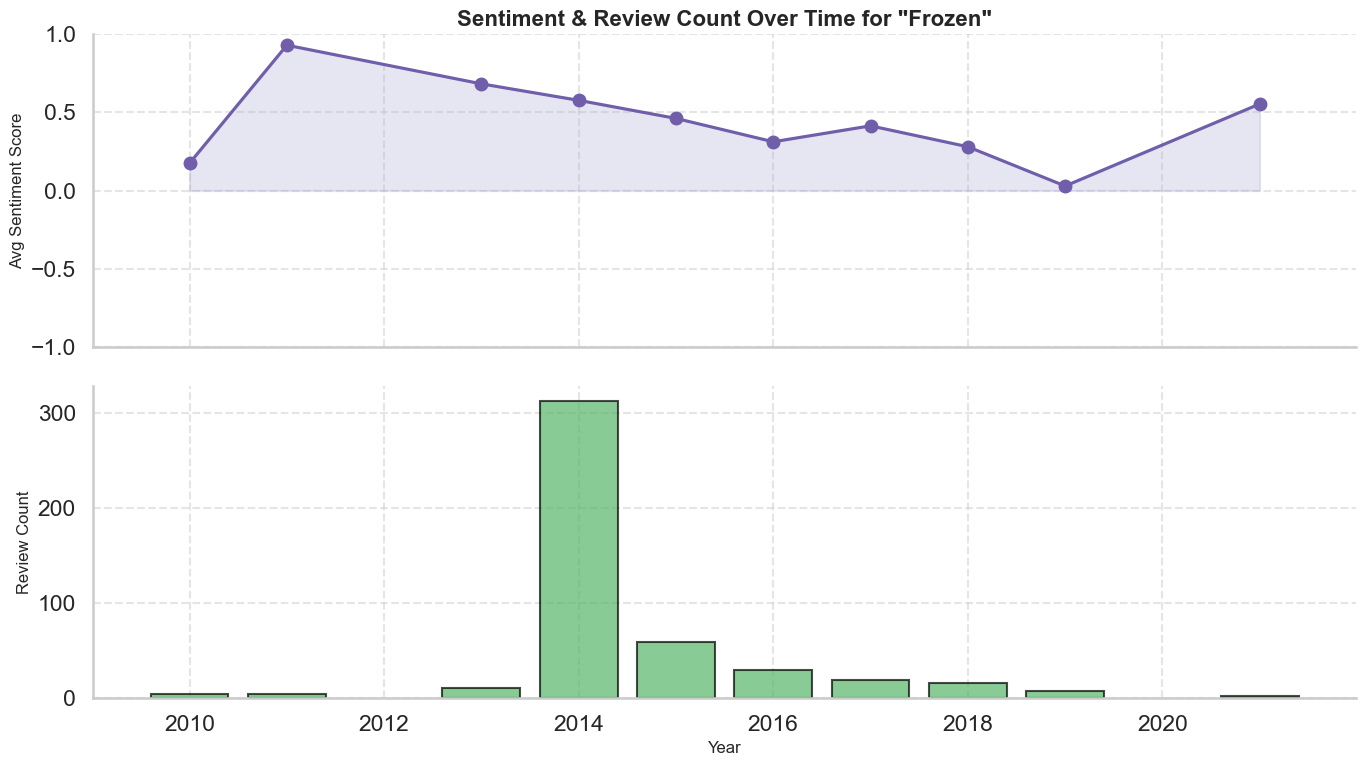

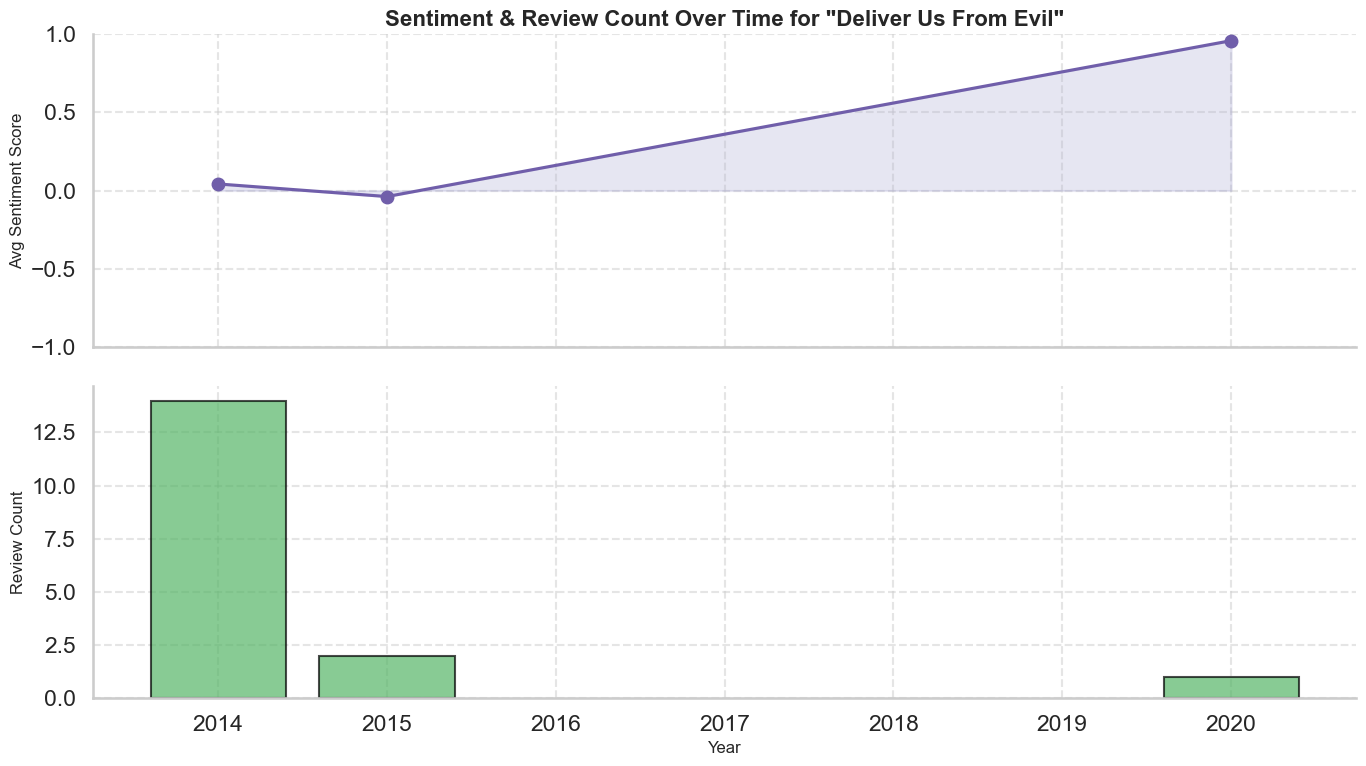

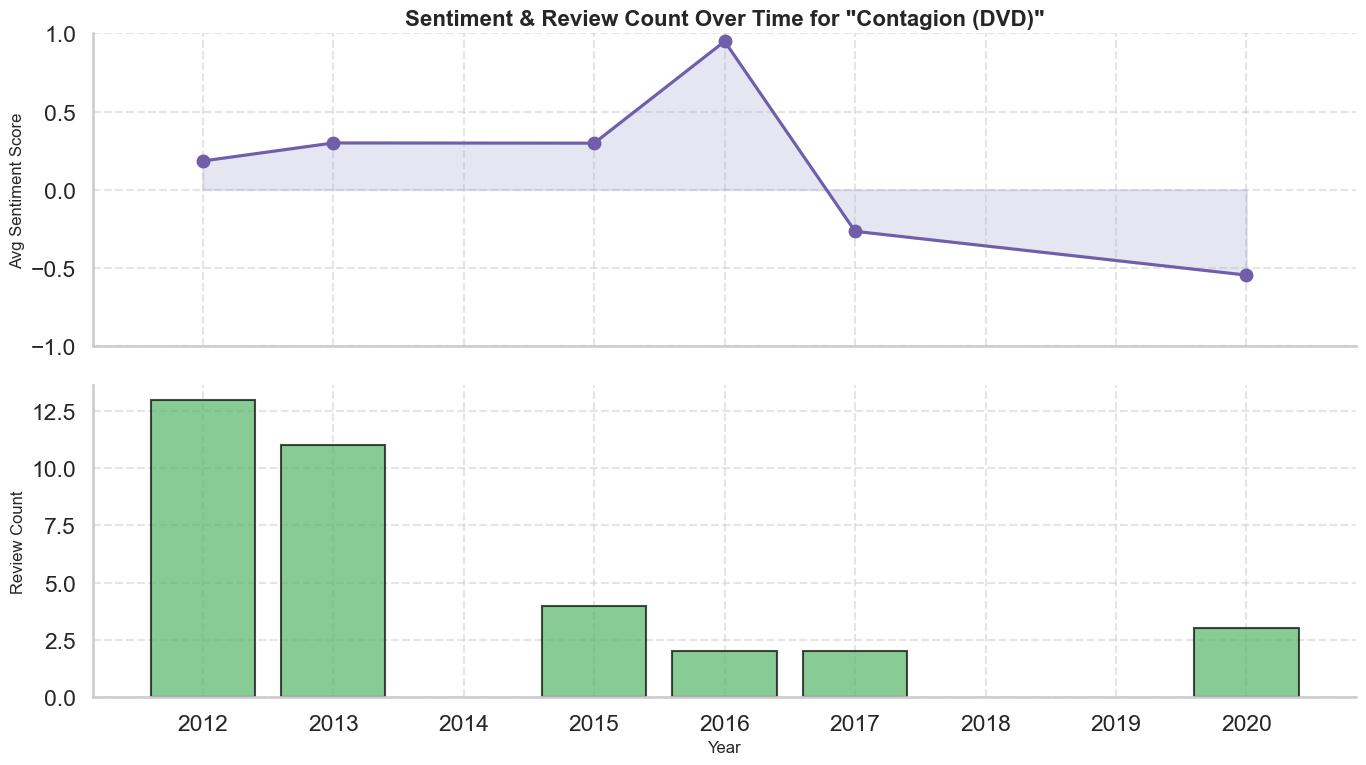

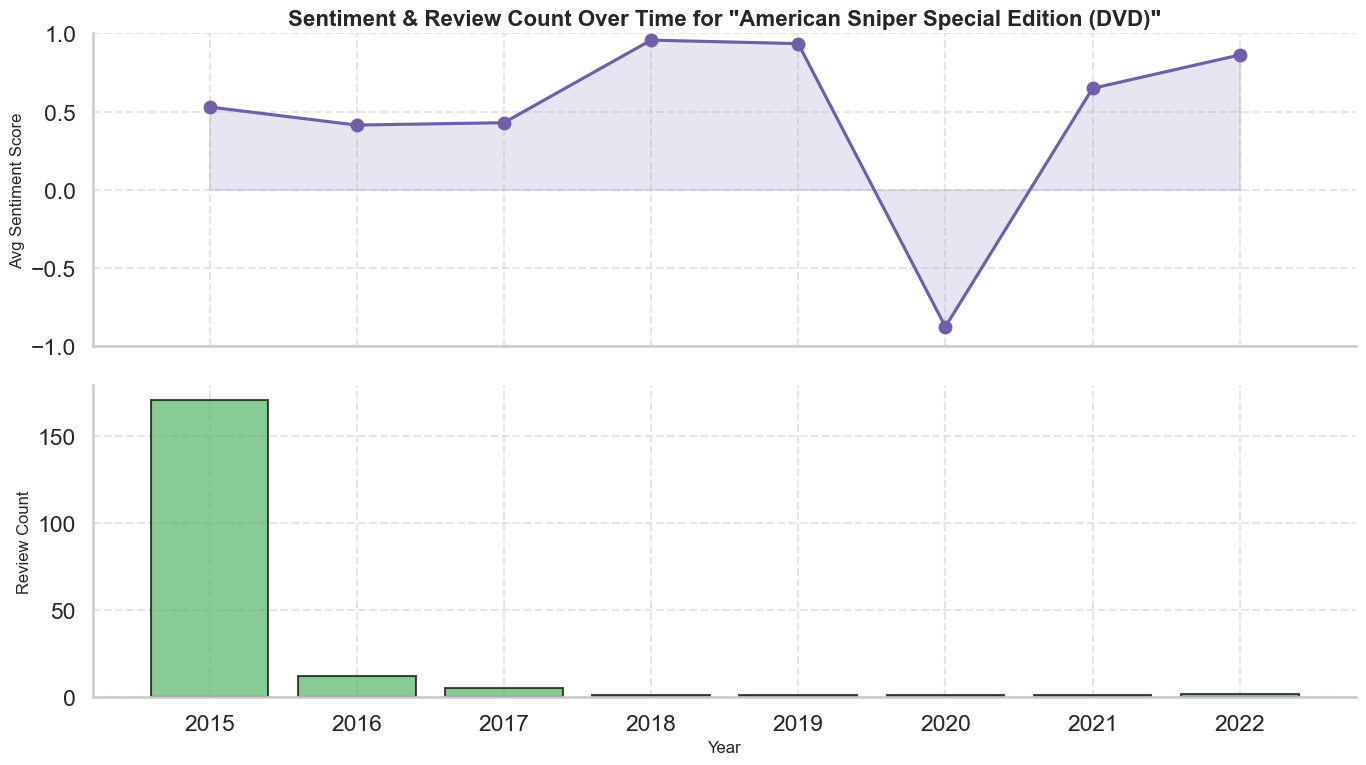

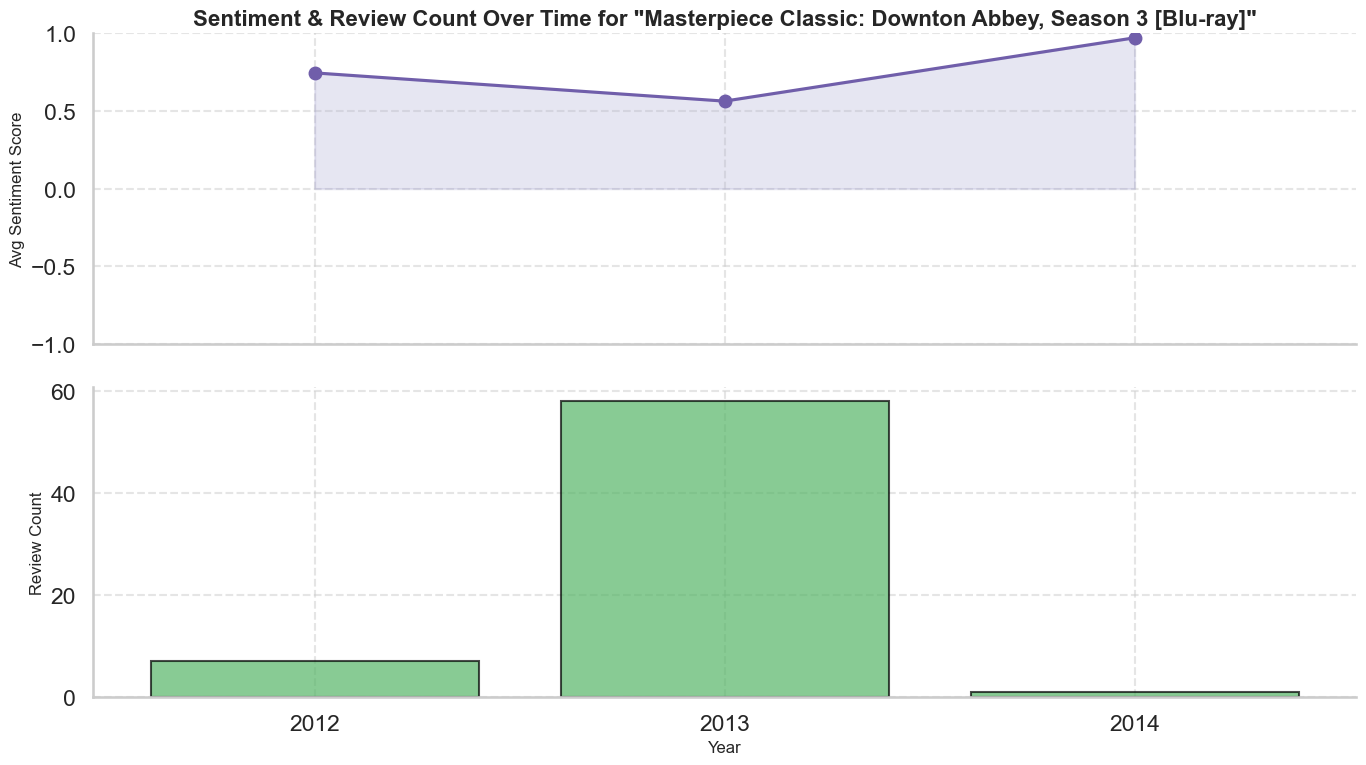

In [140]:
sns.set(style="whitegrid", context="talk")

for movie, _ in focus_list:
    df_item = df[df["movie_title"] == movie].copy()

    # Convert Unix timestamps to date (from ms to datetime.year)
    df_item["date"] = pd.to_datetime(df_item["timestamp"], unit='ms').dt.year

    avg_sentiment = df_item.groupby("date")["sentiment_score"].mean()
    review_count = df_item.groupby("date")["sentiment_score"].count()

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

    # Plot 1: Sentiment Trend (Line + area fill, purple)
    ax1.plot(avg_sentiment.index, avg_sentiment.values, marker='o', color=sns.color_palette("Purples")[4])
    ax1.fill_between(avg_sentiment.index, avg_sentiment.values, color=sns.color_palette("Purples")[2], alpha=0.3)
    ax1.set_ylabel("Avg Sentiment Score", fontsize=12)
    ax1.set_ylim(-1, 1)
    ax1.grid(True, linestyle='--', alpha=0.5)
    ax1.set_title(f"Sentiment & Review Count Over Time for \"{movie}\"", fontsize=16, weight='bold')

    # Plot 2: Review Count (Bar plot, green)
    ax2.bar(review_count.index, review_count.values, color=sns.color_palette("Greens")[3], edgecolor='black', alpha=0.7)
    ax2.set_ylabel("Review Count", fontsize=12)
    ax2.set_xlabel("Year", fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.5)

    ax2.xaxis.set_major_locator(MaxNLocator(integer=True)) # remove the decimal points in the year

    sns.despine()
    plt.tight_layout()
    plt.show()


### Word clouds for the identified communities

In this section we be doing the following for each community:
- Preprocess and tokenize all reviews in the community
- Calculate TF-IDF scores.
- Create a word cloud for each community based on the calculated TF-IDF scores.

#### Tokenization and pre-processing of review text

Note that the following function has been taken from Assignment 2 part 3

In [85]:
stemmer = PorterStemmer() # initialise a stemmer 
stop_words = set(stopwords.words('english'))  # load stopwords (to remove common words later)


def preprocess_text(given_text):

    # convert to lowercase
    given_text = given_text.lower()

    # remove URLs, punctuation, numbers, and mathematical symbols
    given_text = re.sub(r"http\S+|www\S+", "", given_text)  # remove URLs
    given_text = re.sub(r"[^a-zA-Z\s]", "", given_text)  # keep only letters and spaces
    
    # tokenize
    tokens = word_tokenize(given_text)
    
    # remove stopwords and apply stemming
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    
    return tokens

# apply the function to the text column
df_sentiment['tokens'] = df_sentiment['text'].apply(preprocess_text)

#### TF-IDF + Word clouds for each community

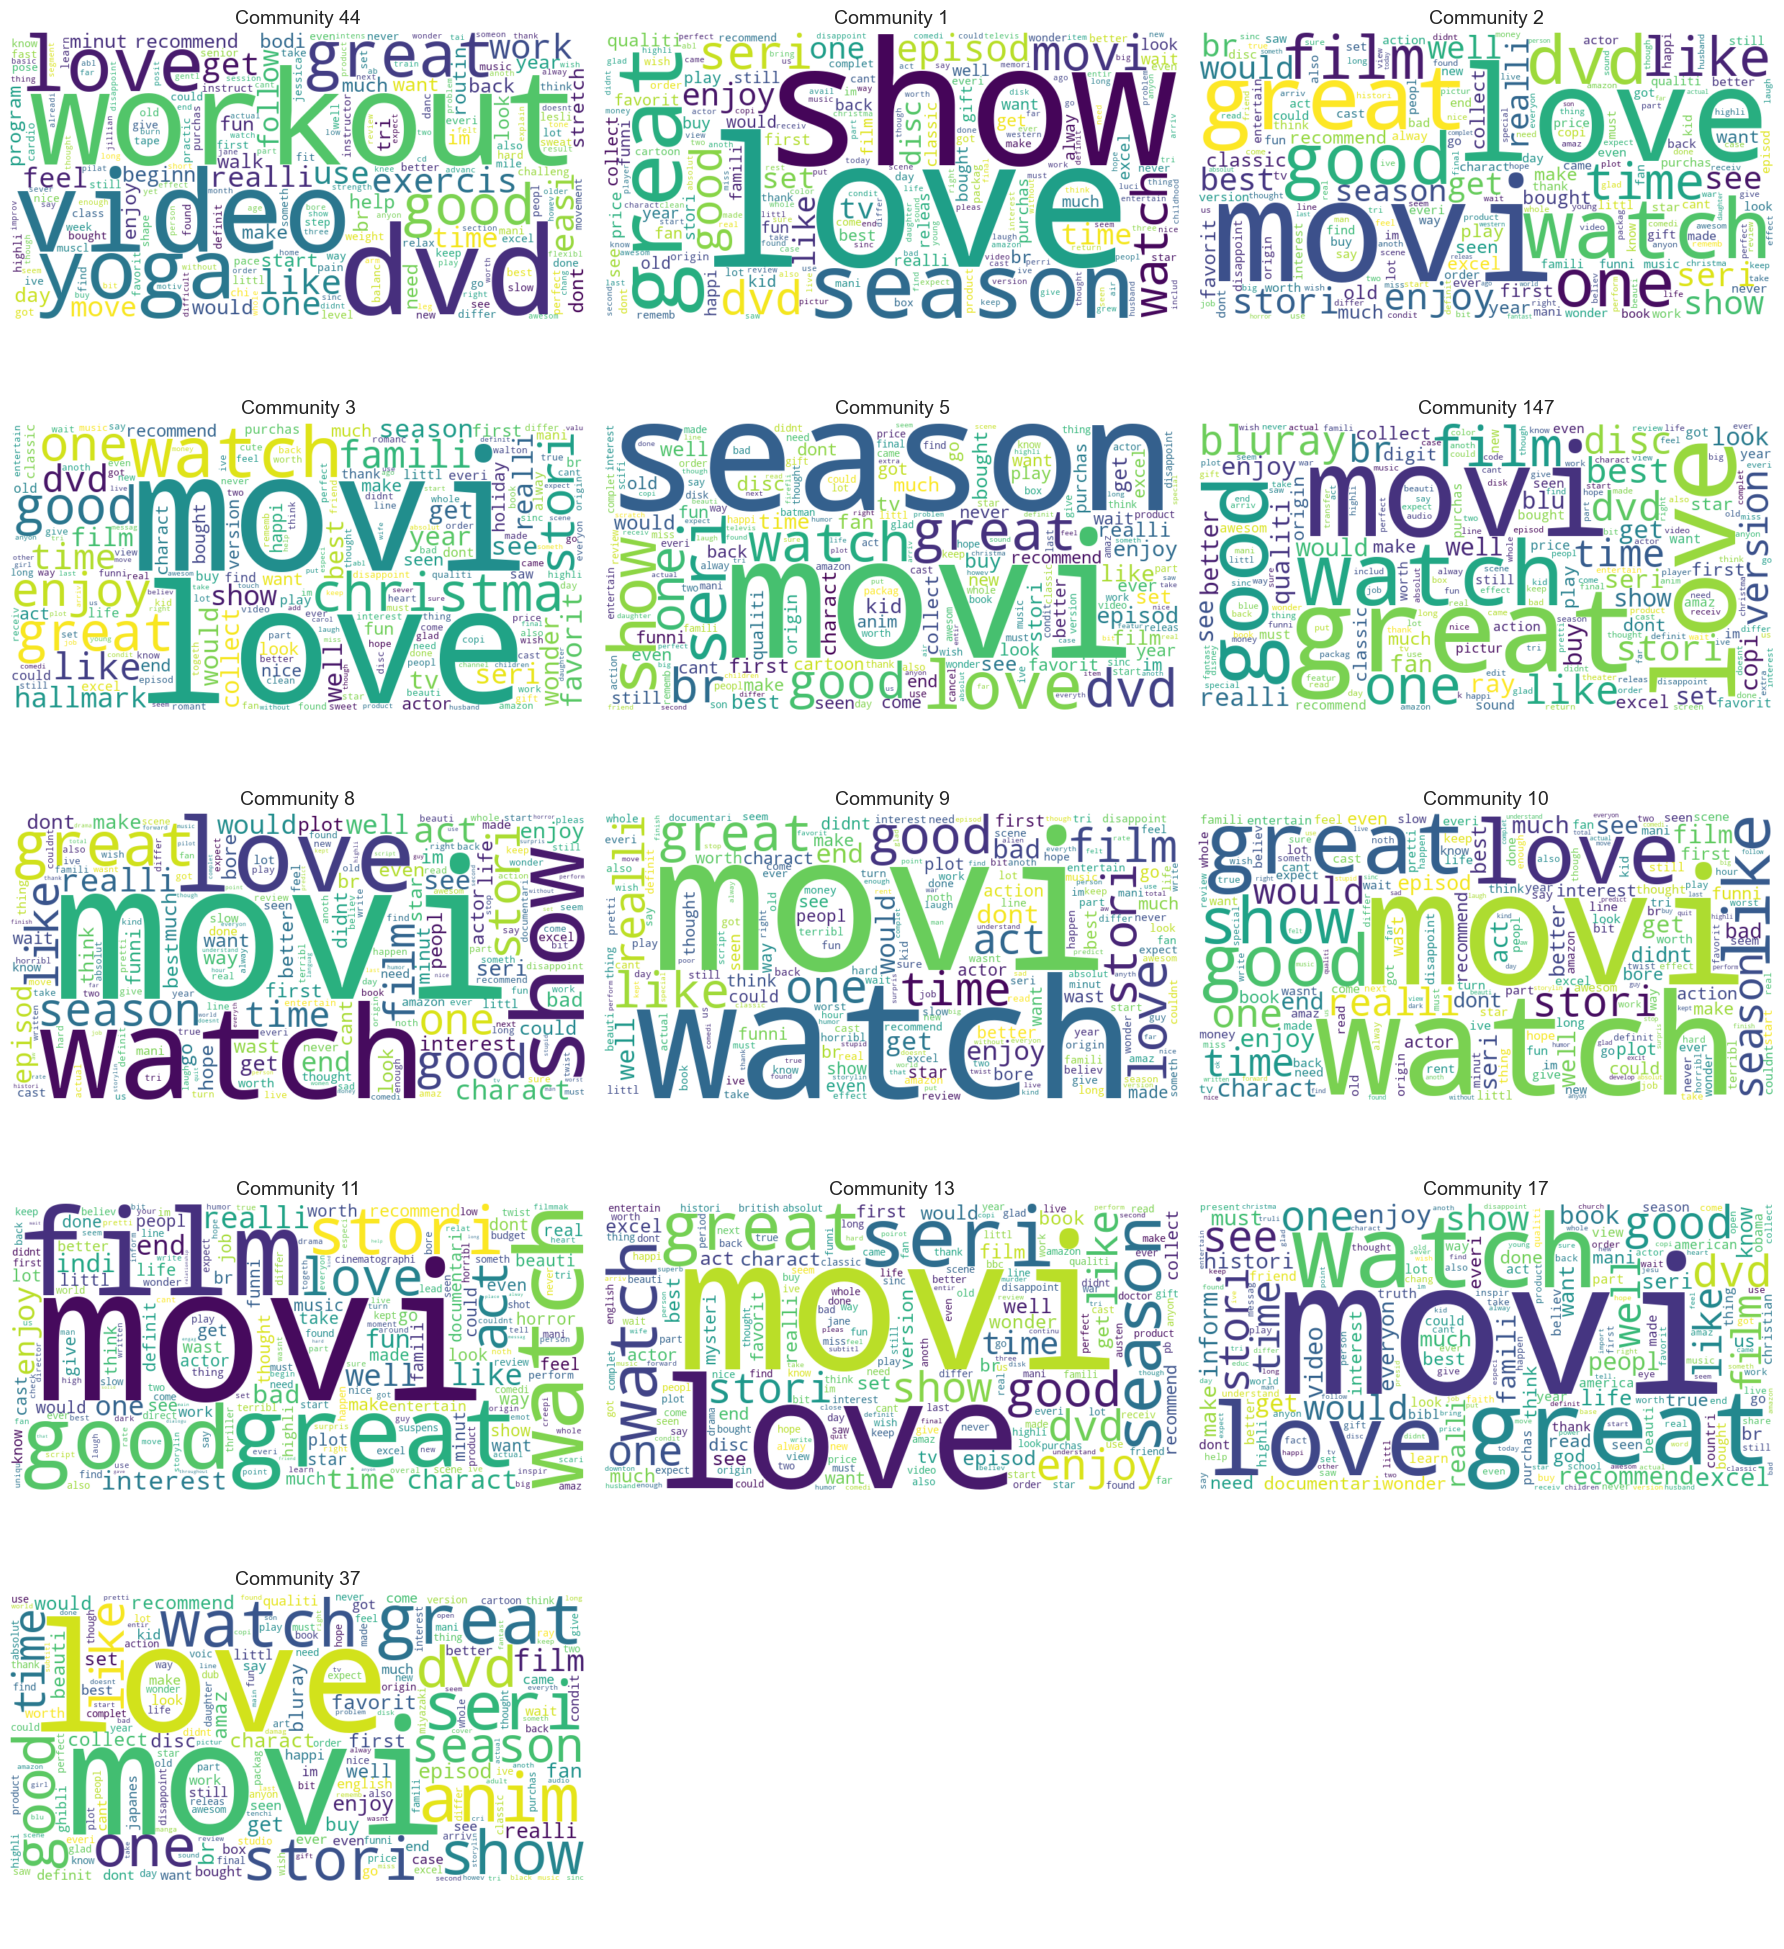

In [ ]:
# initiate list for word clouds
wordclouds = []

for comm_id, asin_list in communities.items():
    comm_df = df_sentiment[df_sentiment['asin'].isin(asin_list)]

    # calculate tf-idf using tokens
    corpus = comm_df['tokens'].tolist() # get the tokenized text
    total_docs = len(corpus) # total number of documents in the corpus i.e., reviews

    # calculate document frequency (df) for each term
    df_counter = Counter()
    for tokens in corpus:
        df_counter.update(set(tokens))

    tfidf_scores = defaultdict(float) # to store cumulative tf-idf scores for each term

    for tokens in corpus:
        tf_counter = Counter(tokens)
        doc_len = len(tokens)
        for token, tf in tf_counter.items():
            tf_score = tf / doc_len
            idf_score = math.log((total_docs) / (1 + df_counter[token]))
            tfidf = tf_score * idf_score
            tfidf_scores[token] += tfidf
    
    # make the word cloud from tf-idf
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_scores)
    wordclouds.append((comm_id, wc))

# plot word clouds in one plot (3 per row)
num_wc = len(wordclouds)
cols = 3
rows = math.ceil(num_wc / cols)

fig, axs = plt.subplots(rows, cols, figsize=(18, 4 * rows))
axs = axs.flatten()

for i, (comm_id, wc) in enumerate(wordclouds):
    axs[i].imshow(wc, interpolation='bilinear')
    axs[i].set_title(f"Community {comm_id}", fontsize=14)
    axs[i].axis('off')

# turn off unused subplots (needed for last row)
for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

## Discussion